Here I investigate the different preprocessing in combination with IPF to understand how the results change. 

This script tries the iterative proportional fitting (IPF) algortihm to map gene expression into 3D space. The available data is tomoseq data, which consit of the total counts of a gene (total gene expression) of a slice along one axis (x,y,z). Here x = DV, y = PA and z = LML. As only the marginals (total counts along an axis) are given, the iterative proportional fitting fills the 3D expression matrix (containg the gene expression values) such that the sum of all counts add up to the marginals along each axis. As this is a highly underdetermined problem, multiple solutions exist. Therefore several ideas have been proposed/or need to be tested to receive a solution as close as possible to the true solution.

Here I first try out IPF with the tomoseq data along three different axis to reconstruct the results of the Mouse Olfactory Mucosa dataset (Ruiz Tejada Segura ML, Scialdone A, Saraiva LR. A 3D transcriptomics atlas of the mouse nose sheds light on the anatomical logic of smell. doi: 10.1016/j.celrep.2022.110547. PMID: 35320714; PMCID: PMC8995392.)


In [468]:
#importing packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt


In [469]:
import sys, os
print(sys.executable)
!which pip


/Users/kimjob/opt/anaconda3/envs/py39/bin/python
/Users/kimjob/opt/anaconda3/envs/py39/bin/pip


In [975]:
'Trying the Mouse Olfactory Mucosa dataset'

# normalized dataset

DV_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/DV_RPMnormExpression1D.csv', index_col=0)
PA_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/AP_RPMnormExpression1D.csv', index_col=0)
LML_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/LML_RPMnormExpression1D.csv', index_col=0)

DV_raw_data = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/E-MTAB-10211/DV_datasetNew.2_G99.csv', index_col=0)
LML_raw_data = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/E-MTAB-10211/LML_datasetNew_G99.csv', index_col=0)
PA_raw_data = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/E-MTAB-10211/PA_datasetNew_G99.csv', index_col=0)




# loading fitted data --> This is the data that is being used in the Mouse Olfactory Mucosa paper 

DV_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedDV.csv')
PA_axis_fitted =  pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedAP.csv')
LML_axis_fitted =  pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedLML.csv')


# loading volume of the slices along each axis

volume_PA = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolAP.csv')
volume_DV = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolDV.csv')
volume_LML = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolLML.csv')

# loading mask --> Defines the shape of the sample (Here the Mouse Mucosa)

mask = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/mask.csv')


In [976]:
DV_axis_fitted

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54
0,56.444722,54.999212,53.600642,52.248657,50.942900,49.683013,48.468641,47.299426,46.175012,45.095042,...,32.105328,32.157351,32.227625,32.316120,32.422801,32.547637,32.690595,32.851644,33.030751,33.227883
1,1.050600,1.014316,0.980266,0.948426,0.918775,0.891290,0.865948,0.842727,0.821605,0.802558,...,0.818121,0.799493,0.779124,0.757014,0.733162,0.707566,0.680227,0.651143,0.620314,0.587739
2,2.330708,2.406392,2.477433,2.543872,2.605748,2.663100,2.715969,2.764394,2.808414,2.848070,...,2.411032,2.418744,2.429439,2.443162,2.459962,2.479886,2.502980,2.529291,2.558867,2.591754
3,38.387130,36.993393,35.660534,34.388424,33.176935,32.025938,30.935305,29.904906,28.934614,28.024299,...,24.908920,24.771741,24.610315,24.424166,24.212819,23.975798,23.712628,23.422834,23.105940,22.761471
4,2.750410,2.699102,2.648833,2.599633,2.551531,2.504557,2.458740,2.414110,2.370696,2.328529,...,1.782306,1.766554,1.749499,1.731081,1.711245,1.689932,1.667086,1.642649,1.616563,1.588771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17623,834.339854,804.391039,775.215508,746.819380,719.208776,692.389816,666.368619,641.151305,616.743995,593.152808,...,302.517166,307.261934,312.612938,318.561543,325.099113,332.217012,339.906605,348.159257,356.966331,366.319193
17624,166.252993,162.310700,158.415208,154.568119,150.771035,147.025557,143.333286,139.695823,136.114770,132.591728,...,68.212414,69.274685,70.517734,71.940721,73.542807,75.323152,77.280916,79.415260,81.725344,84.210329
17625,1670.744889,1641.487795,1611.909915,1582.033382,1551.880326,1521.472878,1490.833170,1459.983332,1428.945495,1397.741790,...,762.119915,777.351555,794.406226,813.262329,833.898268,856.292444,880.423261,906.269121,933.808427,963.019580
17626,11284.236105,11091.024574,10897.012563,10702.304054,10507.003032,10311.213478,10115.039377,9918.584711,9721.953463,9525.249616,...,5490.990755,5610.057298,5744.324866,5893.738950,6058.245041,6237.788627,6432.315201,6641.770252,6866.099271,7105.247748


some data transformation

In [977]:
# modifying dataset, no gene_name is in the fitted data - only in the normalized data. Assume the indexes are correct.

DV_axis_fitted.insert(0, 'gene_name', DV_axis_norm.index.to_list())
PA_axis_fitted.insert(0, 'gene_name', PA_axis_norm.index.to_list())
LML_axis_fitted.insert(0, 'gene_name', LML_axis_norm.index.to_list())

# rename gene column properly
DV_axis_fitted = DV_axis_fitted.set_index('gene_name')
PA_axis_fitted = PA_axis_fitted.set_index('gene_name')
LML_axis_fitted = LML_axis_fitted.set_index('gene_name')


# rename also normalized data  --> is this really needed?

DV_axis_norm.rename(columns={'Unnamed: 0':'gene_name'}, inplace=True)
PA_axis_norm.rename(columns={'Unnamed: 0':'gene_name'}, inplace=True)
LML_axis_norm.rename(columns={'Unnamed: 0':'gene_name'}, inplace=True)

# transform volume to correct shape

volume_DV = volume_DV.iloc[:, 0]
volume_PA = volume_PA.iloc[:, 0]
volume_LML = volume_LML.iloc[:, 0]

Creating the mask

In [978]:
""" 
Defining the mask considering the shape of the biological sample. 

"""

DV_size = mask["DV"].max()     # = 54
LML_size = mask["LML"].max()   # = 56
PA_size = mask["AP"].max()     # = 60

mask_tensor = np.zeros((DV_size, LML_size, PA_size))

# Fill in the tensor with values

for row in mask.itertuples(index=False):
    dv, lml, ap, val = row
    # Subtract 1 to convert from 1-based to 0-based indexing
    mask_tensor[dv - 1, lml - 1, ap - 1] = val


IPF code including the mask

In [979]:
def av_gene_counts(gene, logNormLML, logNormAP, logNormDV):
    
    total_lml = logNormLML.loc[gene].astype(float).sum()
    total_ap = logNormAP.loc[gene].astype(float).sum()
    total_dv = logNormDV.loc[gene].astype(float).sum()
    return np.mean([total_lml, total_ap, total_dv])


You need to impor tthe seed-3d matrix from the R code of Mayra and use it here! This is important to reproduce the results

In [980]:
# save reader for R-files such that the exact seed.3d and mask from R can be used here
%pip install pyreadr

Note: you may need to restart the kernel to use updated packages.


In [981]:
import pyreadr
# and then
res = pyreadr.read_r('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/seed3d.rds')

#res2 = pyreadr.read_r('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/mask3d.rds')


In [982]:
seed_r = res[None]            # this is an xarray.DataArray
seed_r = seed_r.values        # now shape = (54,56,60) just like in R#
seed_r

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Applying IPF to a specific gene of interest. This part visualizes the gene expression in 3D as a 2D plot, where one slice (this can be chosen) is fixed and only the expression of that slice is being showed. This is visualized for all three axes AP, DV, LML. As an example: If you fix a slice along the AP axis, the 2D plot (heatmap) shows the gene expression of DV vs LML. 

The gene expression along the 1D-axes (AP, LML, DV) is also shown, included the fitted gene expression.

In [983]:
# THIS WORKS  !!!!!!!# fiiiinnally managed to reproduce Mayras results

""" IPF function """

# 1) IPF function

def ipf_3d(seed, target_x, target_y, target_z,
           precision=1e-10, max_iters=1000):
    prev_x = np.sum(seed, axis=(1,2))
    prev_y = np.sum(seed, axis=(0,2))
    prev_z = np.sum(seed, axis=(0,1))
    
    for h in range(max_iters):
        # DV-slices → match target_x
        for i in range(seed.shape[0]):
            s = np.nansum(seed[i])
            if s>0:
                seed[i] *= (target_x[i]/s)
        # LML-slices → match target_y
        for j in range(seed.shape[1]):
            s = np.nansum(seed[:,j])
            if s>0:
                seed[:,j] *= (target_y[j]/s)
        # PA-slices → match target_z
        for k in range(seed.shape[2]):
            s = np.nansum(seed[:,:,k])
            if s>0:
                seed[:,:,k] *= (target_z[k]/s)
        
        new_x = np.sum(seed, axis=(1,2))
        new_y = np.sum(seed, axis=(0,2))
        new_z = np.sum(seed, axis=(0,1))
        
        if (np.allclose(new_x, prev_x, atol=precision) and
            np.allclose(new_y, prev_y, atol=precision) and
            np.allclose(new_z, prev_z, atol=precision)):
            break
        
        prev_x, prev_y, prev_z = new_x, new_y, new_z

    return np.nan_to_num(seed)

In [984]:
# THIS WORKS  !!!!!!!# fiiiinnally managed to reproduce Mayras results

# 2) define the input dat for the specific gene of interest

gene_ipf = "Cytl1"

# ---------------------------- Preprocessing input data ---------------------------- #

target_DV = DV_axis_fitted.loc[gene_ipf].values * volume_DV.values / volume_DV.sum()
target_PA = PA_axis_fitted.loc[gene_ipf].values * volume_PA.values / volume_PA.sum()
target_LML = LML_axis_fitted.loc[gene_ipf].values * volume_LML.values / volume_LML.sum()

# Use normalized expression (not fitted) to reflect actual counts
av_gene_counts = np.mean([
    np.sum(PA_axis_norm.loc[gene_ipf].values),
    np.sum(DV_axis_norm.loc[gene_ipf].values),
    np.sum(LML_axis_norm.loc[gene_ipf].values)
])


"""# Rescale 1D projections to sum to average observed expression
target_DV *= av_gene_counts / np.sum(target_DV)
target_PA *= av_gene_counts / np.sum(target_PA)
target_LML *= av_gene_counts / np.sum(target_LML)"""

# Ensure numerical consistency
target_DV = target_DV.astype(np.float64)
target_PA = target_PA.astype(np.float64)
target_LML = target_LML.astype(np.float64)


# Input data without volume normalization #



target_DV_no_volume = DV_axis_fitted.loc[gene_ipf].values
target_PA_no_volume = PA_axis_fitted.loc[gene_ipf].values
target_LML_no_volume = LML_axis_fitted.loc[gene_ipf].values

# ---------------------------- Seed function -------------------------------------- #

# 3) MATCH THE R SEED
np.random.seed(200)    # <-- whatever you used in R, e.g. set.seed(200)

#seed_3d = np.random.rand(len(target_DV), len(target_LML), len(target_PA))

# use here the seed_3d from R to reproduce exactly the results from Mayra
seed_3d = seed_r
seed_3d *= mask_tensor   # apply your tissue mask exactly once

# --------------------------------------------------------------------------------- #
# --------------------------------------- run IPF --------------------------------- #


# 5) RUN IPF
proj_mayra = ipf_3d(seed_3d.copy(), target_DV, target_LML, target_PA)
proj_no_volume = ipf_3d(seed_3d.copy(), target_DV_no_volume, target_LML_no_volume, target_PA_no_volume)

# scaling

proj_scaled_mayra = proj_mayra * (av_gene_counts / proj_mayra.sum())
proj_scaled_no_volume =  proj_no_volume * (av_gene_counts / proj_no_volume.sum())

proj_3d_mayra     = np.log10(proj_scaled_mayra + 1)
proj_3d_no_volume = np.log10(proj_scaled_no_volume + 1)
# --------------------------------------------------------------------------------- #
# --------------------------------------------------------------------------------- #



In [985]:
dv_plot = DV_axis_norm.loc['Cytl1'].values.tolist()
lml_plot = LML_axis_norm.loc['Cytl1'].values.tolist()
pa_plot = PA_axis_norm.loc['Cytl1'].values.tolist()

list_dv = np.arange(1,len(dv_plot)+1)
list_lml = np.arange(1,len(lml_plot)+1)
list_pa = np.arange(1,len(pa_plot)+1)

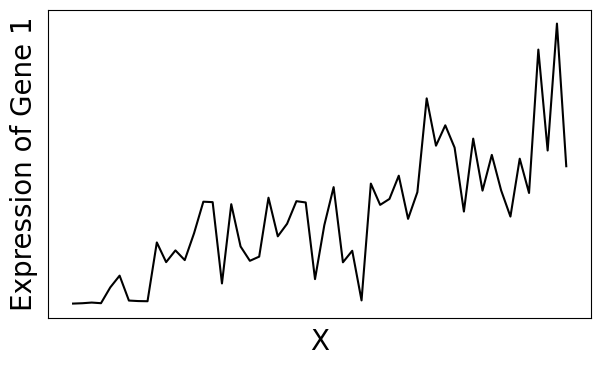

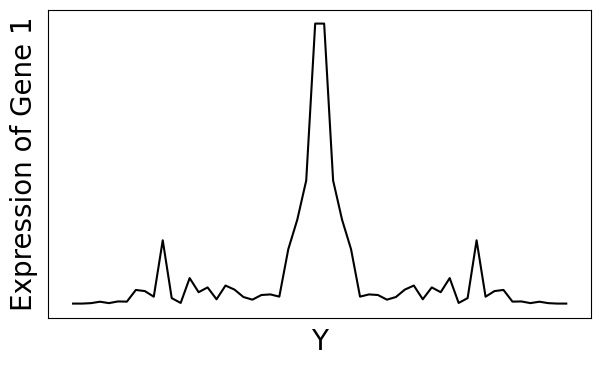

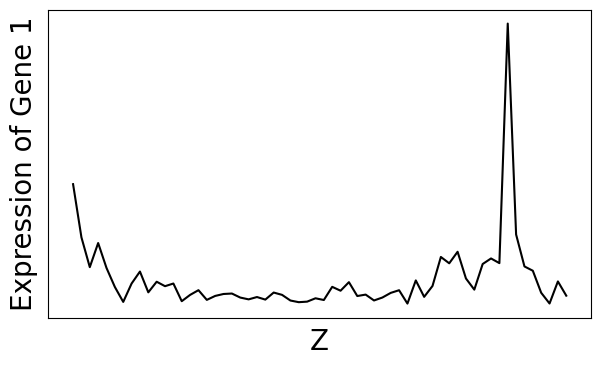

In [986]:
plt.figure(figsize=(7, 4))
plt.plot(list_dv,dv_plot, c='k')
plt.xlabel("X", fontsize=20)
plt.ylabel("Expression of Gene 1", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(list_lml,lml_plot, c='k')
plt.xlabel("Y", fontsize=20)
plt.ylabel("Expression of Gene 1", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(list_pa,pa_plot, c='k')
plt.xlabel("Z", fontsize=20)
plt.ylabel("Expression of Gene 1", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()


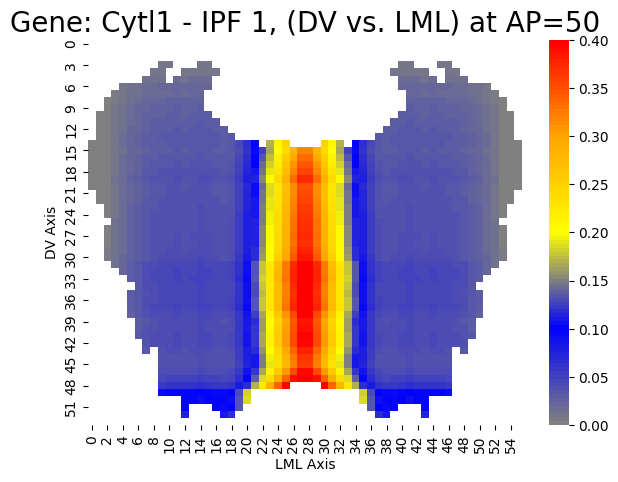

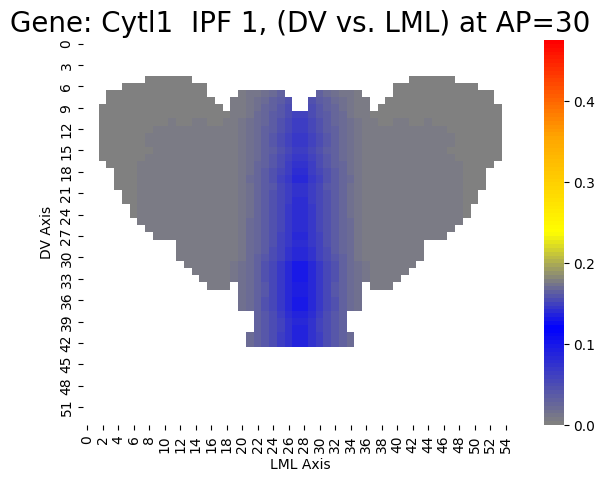

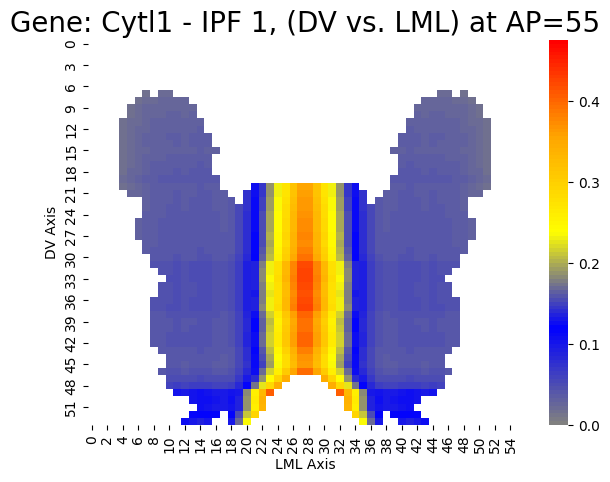

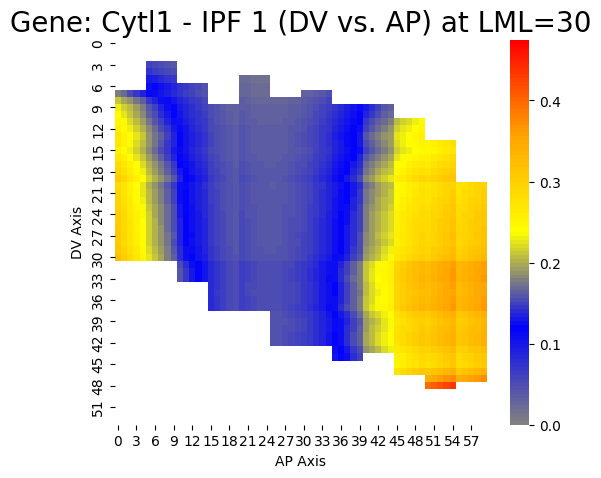

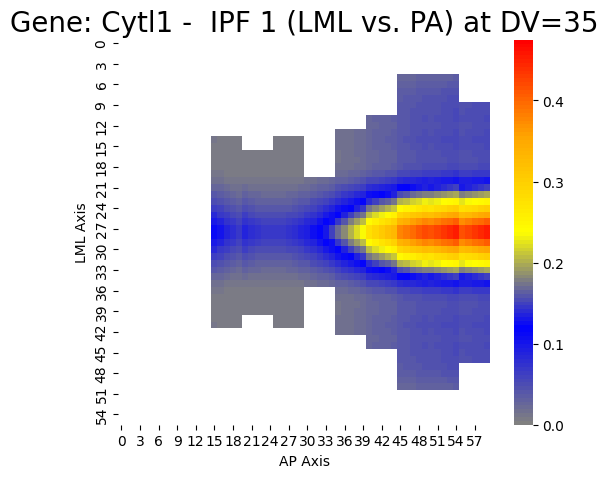

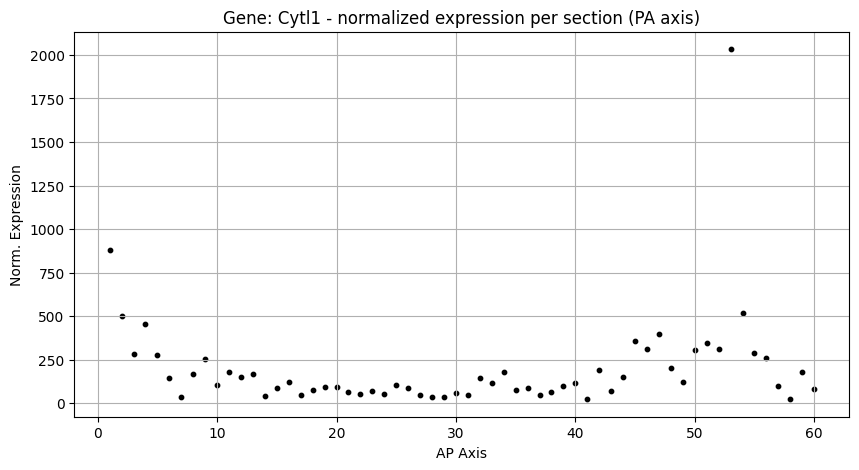

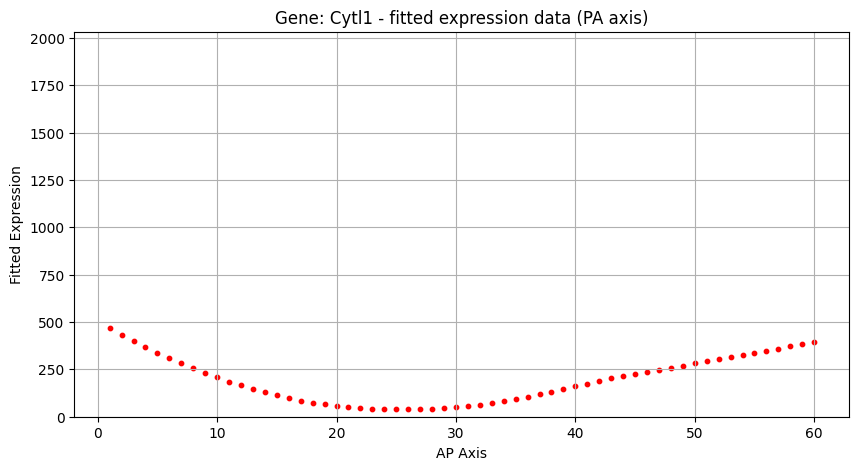

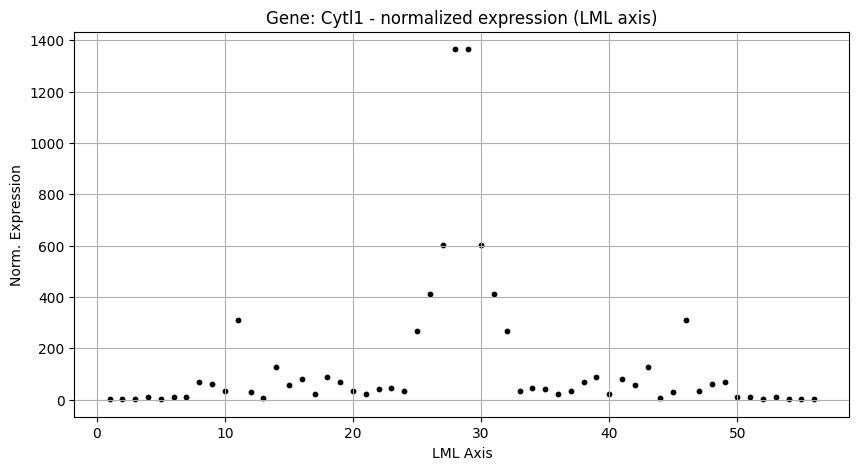

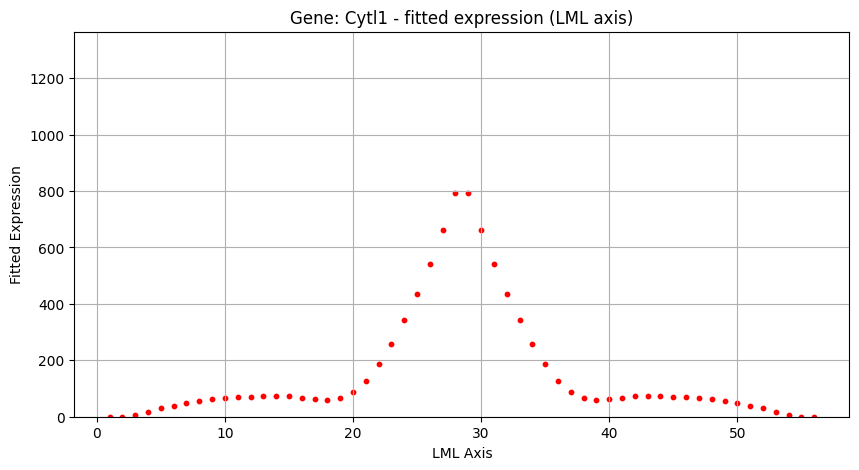

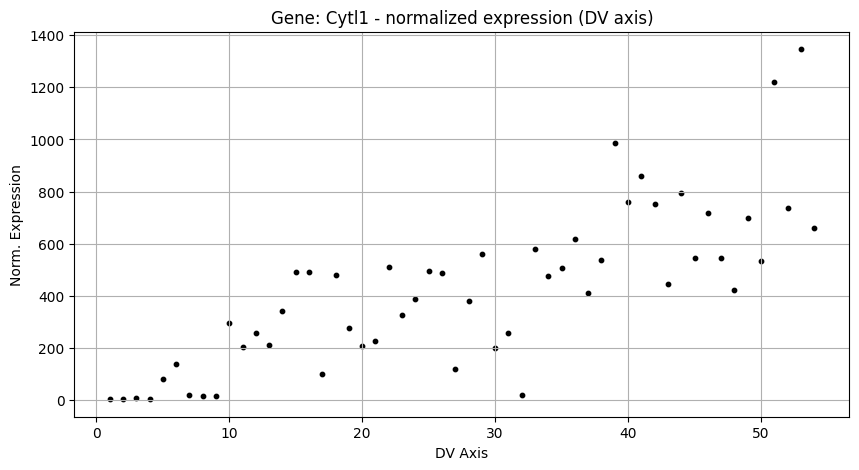

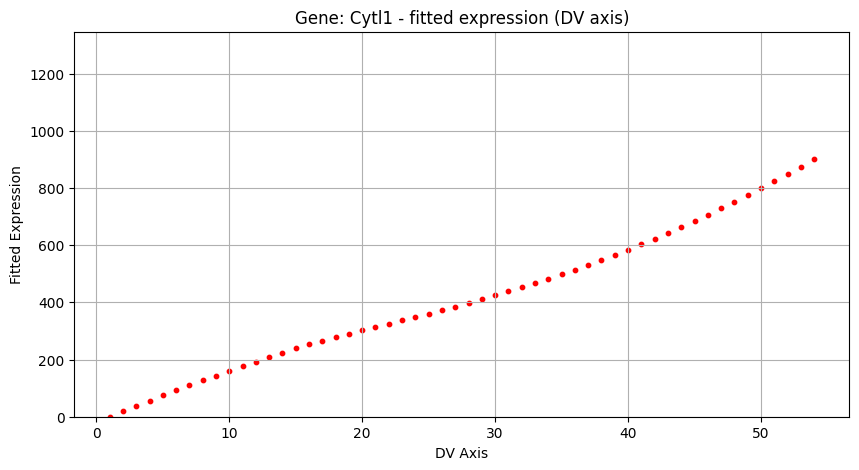

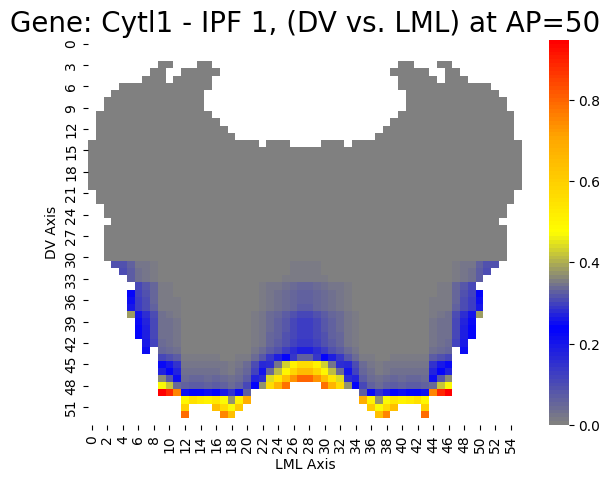

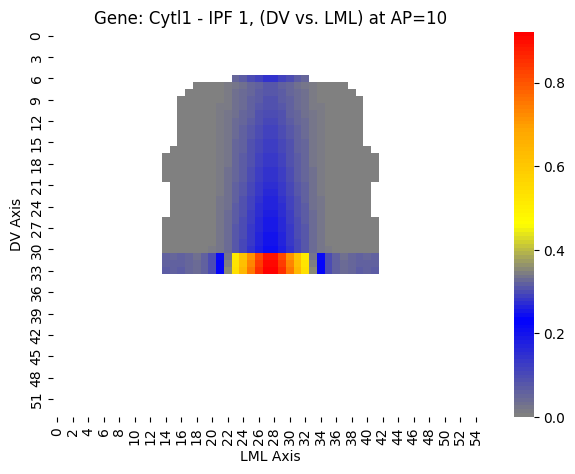

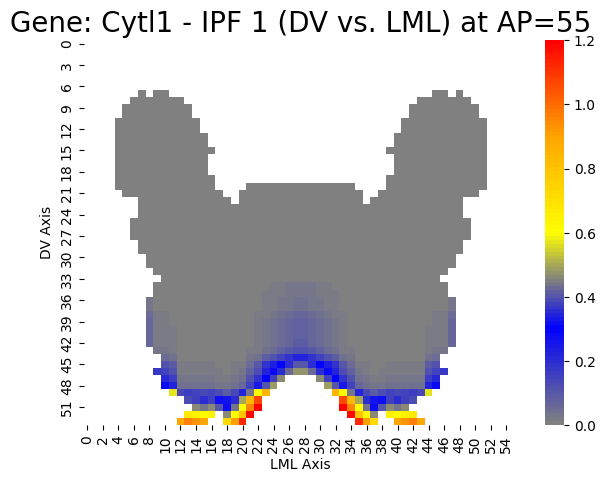

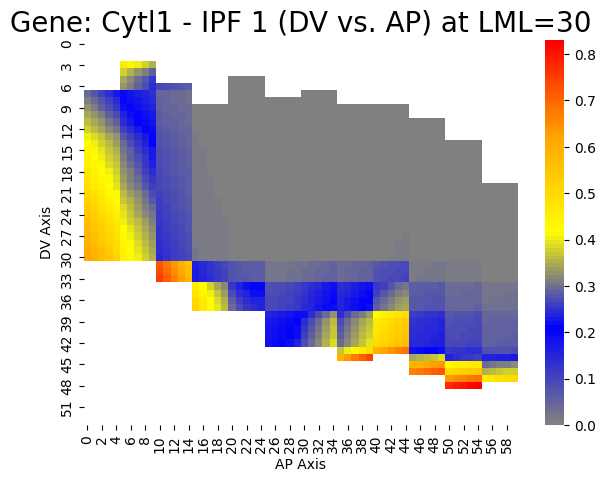

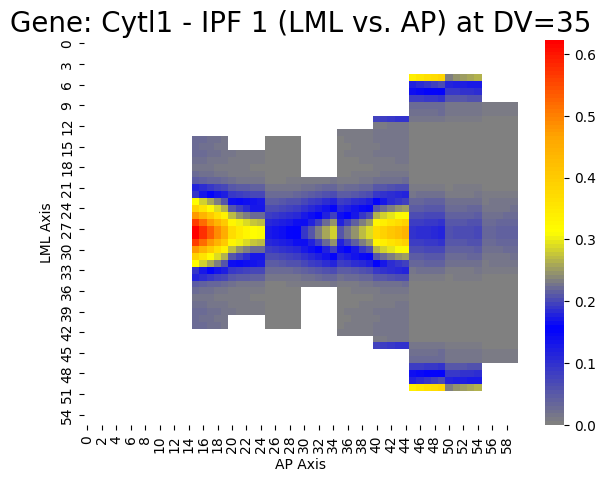

In [1061]:
# THIS WORKS  !!!!!!!# fiiiinnally managed to reproduce Mayras results

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)


# ---------------------------- DV slices ---------------------------- #
white_cmap = ListedColormap(["white"])

# Slice along PA axis
slice_idx = 50
pa_slice = proj_3d_mayra[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.4,  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 1, (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 30
pa_slice = proj_3d_mayra[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=proj_3d_mayra.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1  IPF 1, (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 55
pa_slice = proj_3d_mayra[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=proj_3d_mayra.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 1, (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = proj_3d_mayra[:, slice_idx, :]
mask_lml_slice = mask_tensor[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(lml_slice, cmap=r_palette,  annot=False, vmin=0, vmax=proj_3d_mayra.max())
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - IPF 1 (DV vs. AP) at LML={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()
# Slice along DV axis
slice_idx = 35
dv_slice = proj_3d_mayra[slice_idx, :, :]
mask_dv_slice = mask_tensor[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(dv_slice, cmap=r_palette, annot=False, vmin=0, vmax=proj_3d_mayra.max())
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 -  IPF 1 (LML vs. PA) at DV={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()



# ----------------------------  Visualize 1D Expression ---------------------------- #

# 1D AP (PA) axis
x = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, PA_axis_norm.loc[gene_ipf].values, s=10, c='k')
plt.title(f"Gene: Cytl1 - normalized expression per section (PA axis)")
plt.xlabel("AP Axis")
plt.ylabel("Norm. Expression")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(x, PA_axis_fitted.loc[gene_ipf].values, s=10, c='r')
plt.title(f"Gene: Cytl1 - fitted expression data (PA axis)")
plt.xlabel("AP Axis")
plt.ylabel("Fitted Expression")
plt.ylim(0, PA_axis_norm.loc[gene_ipf].values.max())
plt.grid()
plt.show()

# 1D LML axis
x = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, LML_axis_norm.loc[gene_ipf].values, s=10, c='k')
plt.title(f"Gene: Cytl1 - normalized expression (LML axis)")
plt.xlabel("LML Axis")
plt.ylabel("Norm. Expression")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(x, LML_axis_fitted.loc[gene_ipf], s=10, c='r')
plt.title(f"Gene: Cytl1 - fitted expression (LML axis)")
plt.xlabel("LML Axis")
plt.ylabel("Fitted Expression")
plt.ylim(0, LML_axis_norm.loc[gene_ipf].values.max())
plt.grid()
plt.show()

# 1D DV axis
x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, DV_axis_norm.loc[gene_ipf].values, s=10, c='k')
plt.title(f"Gene: Cytl1 - normalized expression (DV axis)")
plt.xlabel("DV Axis")
plt.ylabel("Norm. Expression")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(x, DV_axis_fitted.loc[gene_ipf].values, s=10, c='r')
plt.title(f"Gene: Cytl1 - fitted expression (DV axis)")
plt.xlabel("DV Axis")
plt.ylabel("Fitted Expression")
plt.ylim(0, DV_axis_norm.loc[gene_ipf].values.max())
plt.grid()
plt.show()


#### ---------------------------------------------------------------------------------------------------------------------------------------- ###
### Same plots but without volume normalization ####

# Slice along PA axis
slice_idx = 50
pa_slice = proj_3d_no_volume[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 1, (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 10
pa_slice = proj_3d_no_volume[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 1, (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 55
pa_slice = proj_3d_no_volume[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 1 (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = proj_3d_no_volume[:, slice_idx, :]
mask_lml_slice = mask_tensor[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(lml_slice, cmap=r_palette, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - IPF 1 (DV vs. AP) at LML={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()
# Slice along DV axis
slice_idx = 35
dv_slice = proj_3d_no_volume[slice_idx, :, :]
mask_dv_slice = mask_tensor[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(dv_slice, cmap=r_palette, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 1 (LML vs. AP) at DV={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()



Evaluation IPF performance


In [906]:


def evaluation(pred, true):

    # calculated metrics from input of IPF and summed along the 3D IPF reconstruction (output of IPF) to see how well the IPF performs

    # mean squared error
    mse = np.mean((pred - true)**2)

    # mean absolute error
    map = np.mean(np.abs(pred - true))

    # correlation
    corr_matrix = np.corrcoef(pred, true)
    corr = corr_matrix[0, 1]

    return mse, map, corr




In [907]:
proj_mayra.shape

(54, 56, 60)

In [908]:
# Evaluation of IPF 1 (Mayras IPF)

# IPF Reconstruction
ipf_sum_x = proj_mayra.sum(axis=(1, 2))
ipf_sum_y = proj_mayra.sum(axis=(0, 2))
ipf_sum_z = proj_mayra.sum(axis=(0, 1))

# DV-axis
mse_DV_IPF1, map_DV_IPF1, corr_DV_IPF1 = evaluation(ipf_sum_x, target_DV)

# LML-axis
mse_LML_IPF1, map_LML_IPF1, corr_LML_IPF1 = evaluation(ipf_sum_y, target_LML)

# AP-axis
mse_AP_IPF1, map_AP_IPF1, corr_AP_IPF1 = evaluation(ipf_sum_z, target_PA)

print('IPF1:')
print(f'mse DV: {mse_DV_IPF1}, mse LML: {mse_LML_IPF1}, mse AP: {mse_AP_IPF1}')
print(f'map LML: {map_DV_IPF1}, map LML: {map_LML_IPF1}, map AP: {map_AP_IPF1}')
print(f'corr DV: {corr_DV_IPF1}, corr LML: {corr_LML_IPF1}, corr AP: {corr_AP_IPF1}')


IPF1:
mse DV: 12.422094447059507, mse LML: 0.004084503303251443, mse AP: 2.3049324141899038e-29
map LML: 3.0505109915471205, map LML: 0.03710222981460781, map AP: 2.995751794780214e-15
corr DV: 0.9999999999979575, corr LML: 0.9999999999999942, corr AP: 1.0


IPF1, no vol:
mse DV: 54060.94345412124, mse LML: 7079.1758257175115, mse AP: 1.9163219472536878e-26
map LML: 200.34158912694008, map LML: 51.110023912327456, map AP: 7.697546304067752e-14
corr DV: 0.9999999898620184, corr LML: 0.9999999996329363, corr AP: 1.0


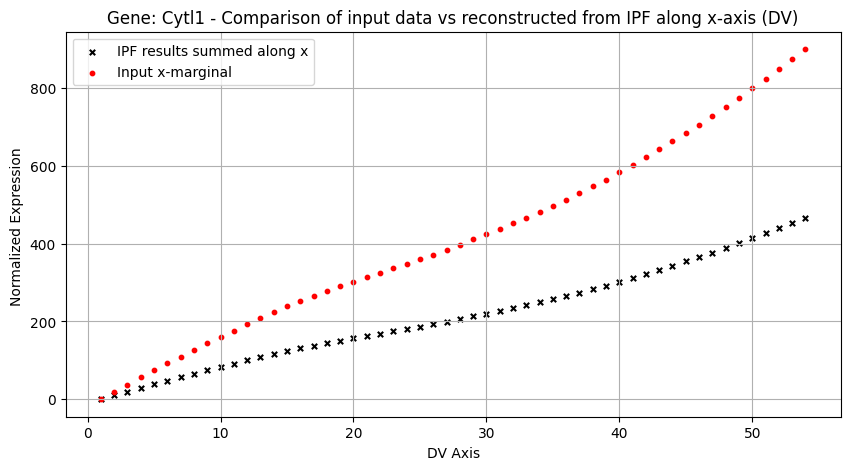

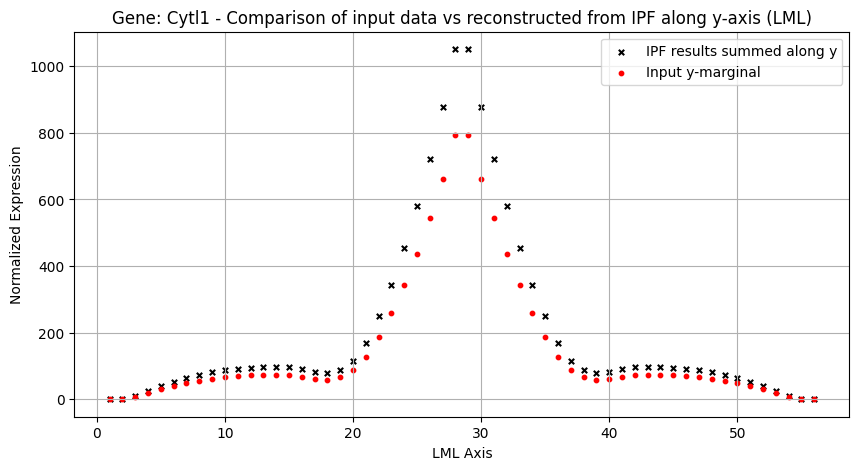

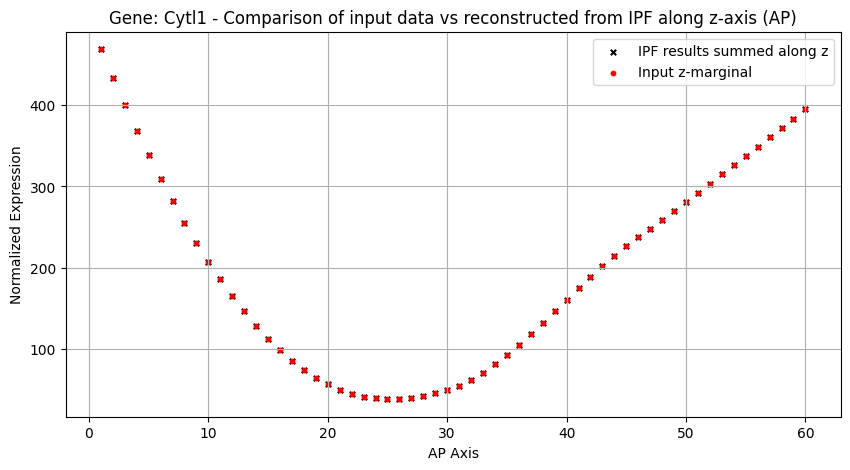

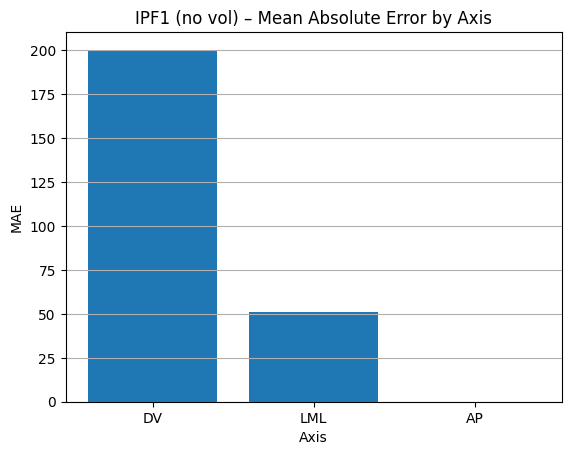

In [1063]:
# Evaluation of IPF 1 (Mayras IPF)

# IPF Reconstruction
ipf_sum_x = proj_no_volume.sum(axis=(1, 2))
ipf_sum_y = proj_no_volume.sum(axis=(0, 2))
ipf_sum_z = proj_no_volume.sum(axis=(0, 1))

# DV-axis
mse_DV_IPF1, map_DV_IPF1, corr_DV_IPF1 = evaluation(ipf_sum_x, target_DV_no_volume)

# LML-axis
mse_LML_IPF1, map_LML_IPF1, corr_LML_IPF1 = evaluation(ipf_sum_y, target_LML_no_volume)

# AP-axis
mse_AP_IPF1, map_AP_IPF1, corr_AP_IPF1 = evaluation(ipf_sum_z, target_PA_no_volume)

print('IPF1, no vol:')
print(f'mse DV: {mse_DV_IPF1}, mse LML: {mse_LML_IPF1}, mse AP: {mse_AP_IPF1}')
print(f'map LML: {map_DV_IPF1}, map LML: {map_LML_IPF1}, map AP: {map_AP_IPF1}')
print(f'corr DV: {corr_DV_IPF1}, corr LML: {corr_LML_IPF1}, corr AP: {corr_AP_IPF1}')



#ipf_results = ipf_3d(seed_3d.copy(), target_DV, target_LML, target_PA)


# draw results

x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, ipf_sum_x, s=15, c='k', marker='x',label= 'IPF results summed along x')
plt.scatter(x, target_DV_no_volume, s=10, c='red', label='Input x-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along x-axis (DV)")
plt.xlabel("DV Axis")
plt.ylabel("Normalized Expression ")
plt.legend()
plt.grid()
plt.show()

y = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(y, ipf_sum_y, s=15, c='k',marker='x',label= 'IPF results summed along y')
plt.scatter(y, target_LML_no_volume, s=10, c='red', label='Input y-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along y-axis (LML)")
plt.xlabel("LML Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

z = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(z, ipf_sum_z, s=15, marker='x', c='k', label= 'IPF results summed along z')
plt.scatter(z, target_PA_no_volume, s=10, c='red', label='Input z-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along z-axis (AP)")
plt.xlabel("AP Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

mae_IPF_no_vol = [200.341, 51.110, 7.697e-14]    # map_* are your MAEs
mae_IPF_no_vol = [3.050, 0.037, 2.996e-15]    # map_* are your MAEs
ipf2_mae = [2.348,2.264,2.113]
ipf2_no_vol_mae = [200.341,51.110,3.991e-5]

tfactomo_mae = [1.891,1.081,1.043]
tfactomo_no_vol_mae = [144.329, 105.122, 50.411]

axes = ['DV', 'LML', 'AP']

# 3) Plot MAE
plt.figure()
plt.bar(axes, mae_IPF_no_vol)
plt.title('IPF1 (no vol) – Mean Absolute Error by Axis')

plt.xlabel('Axis')
plt.ylabel('MAE')
plt.grid(axis='y')
plt.show()





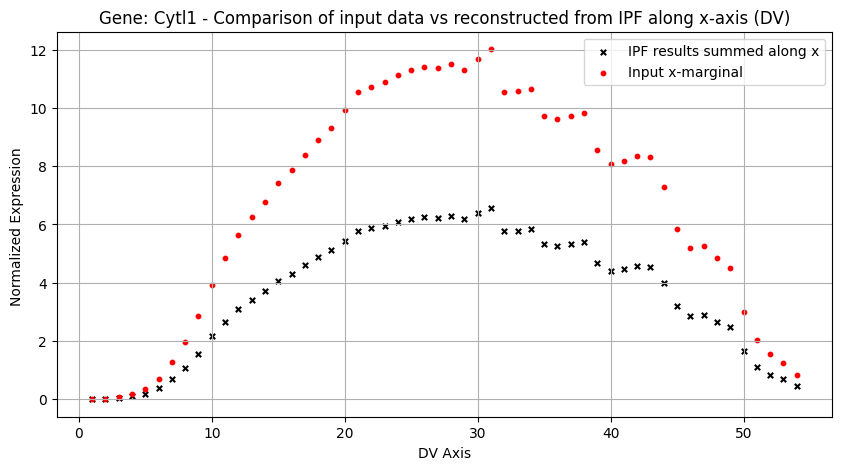

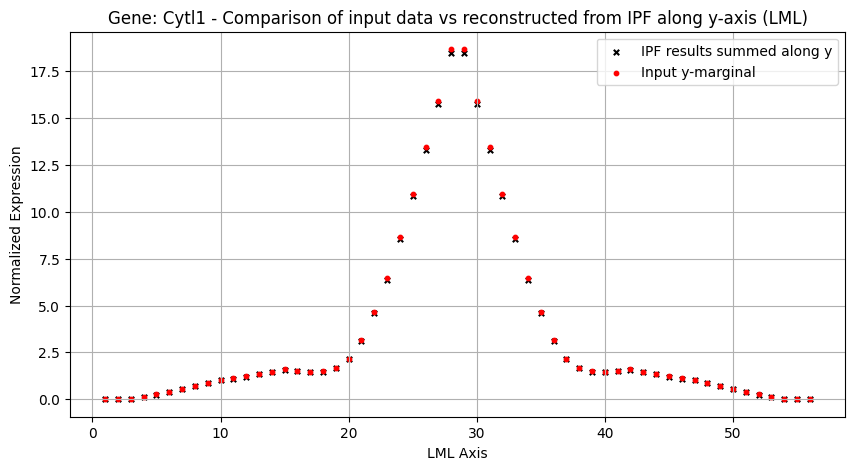

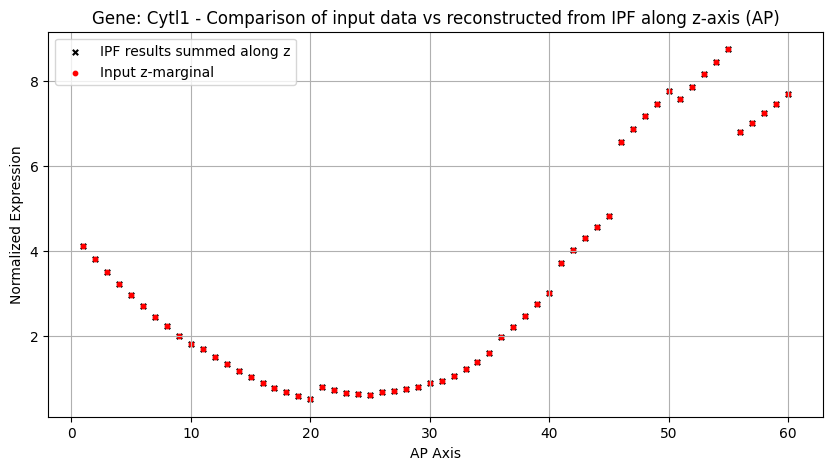

In [909]:

#ipf_results = ipf_3d(seed_3d.copy(), target_DV, target_LML, target_PA)


# draw results

x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, ipf_sum_x, s=15, c='k', marker='x',label= 'IPF results summed along x')
plt.scatter(x, target_DV, s=10, c='red', label='Input x-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along x-axis (DV)")
plt.xlabel("DV Axis")
plt.ylabel("Normalized Expression ")
plt.legend()
plt.grid()
plt.show()

y = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(y, ipf_sum_y, s=15, c='k',marker='x',label= 'IPF results summed along y')
plt.scatter(y, target_LML, s=10, c='red', label='Input y-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along y-axis (LML)")
plt.xlabel("LML Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

z = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(z, ipf_sum_z, s=15, marker='x', c='k', label= 'IPF results summed along z')
plt.scatter(z, target_PA, s=10, c='red', label='Input z-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along z-axis (AP)")
plt.xlabel("AP Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()


In [910]:
PA_gsc = PA_axis_fitted.loc['Gsc'].values.tolist()
DV_gsc = DV_axis_fitted.loc['Gsc'].values.tolist()
LML_gsc = LML_axis_fitted.loc['Gsc'].values.tolist()



In [844]:
"""
x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, DV_gsc, s=15, marker='x', c='k')
plt.title(f"Gene: Gsc - Comparison of input data vs reconstructed from IPF along z-axis (DV)")
plt.xlabel("DV Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

y = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(y, LML_gsc, s=15, marker='x', c='k')
plt.title(f"Gene: Gsc - Comparison of input data vs reconstructed from IPF along z-axis (LML)")
plt.xlabel("LML Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

z = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(z, PA_gsc, s=15, marker='x', c='k')
plt.title(f"Gene: Gsc - Comparison of input data vs reconstructed from IPF along z-axis (AP)")
plt.xlabel("AP Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()"""


'\nx = np.arange(1, len(target_DV) + 1)\nplt.figure(figsize=(10, 5))\nplt.scatter(x, DV_gsc, s=15, marker=\'x\', c=\'k\')\nplt.title(f"Gene: Gsc - Comparison of input data vs reconstructed from IPF along z-axis (DV)")\nplt.xlabel("DV Axis")\nplt.ylabel("Normalized Expression")\nplt.legend()\nplt.grid()\nplt.show()\n\ny = np.arange(1, len(target_LML) + 1)\nplt.figure(figsize=(10, 5))\nplt.scatter(y, LML_gsc, s=15, marker=\'x\', c=\'k\')\nplt.title(f"Gene: Gsc - Comparison of input data vs reconstructed from IPF along z-axis (LML)")\nplt.xlabel("LML Axis")\nplt.ylabel("Normalized Expression")\nplt.legend()\nplt.grid()\nplt.show()\n\nz = np.arange(1, len(target_PA) + 1)\nplt.figure(figsize=(10, 5))\nplt.scatter(z, PA_gsc, s=15, marker=\'x\', c=\'k\')\nplt.title(f"Gene: Gsc - Comparison of input data vs reconstructed from IPF along z-axis (AP)")\nplt.xlabel("AP Axis")\nplt.ylabel("Normalized Expression")\nplt.legend()\nplt.grid()\nplt.show()'

In [845]:
np.random.seed(200)
seed_pert = seed_r.copy()

# 2) Identify tissue voxels (where R’s mask is 1)
nz = mask_tensor.astype(bool)  # True for voxels inside tissue

# 3) Draw noise ~ N(1, 0.05) for each non-zero voxel
noise = np.random.normal(loc=1.0, scale=0.05, size=nz.sum()) #  loc = mean, scale = std --> 0.05 std noise around mean

# 4) Apply it
seed_pert[nz] *= noise

# 5) Clamp any accidental negatives back to zero
seed_pert[seed_pert < 0] = 0



AttributeError: 'Tensor' object has no attribute 'astype'

In [846]:
#### ------------------------------ PERTURBED version ------------------------ ####


# 2) define the input dat for the specific gene of interest

gene_ipf = "Cytl1"

# ---------------------------- Preprocessing input data ---------------------------- #

target_DV = DV_axis_fitted.loc[gene_ipf].values * volume_DV.values / volume_DV.sum()
target_PA = PA_axis_fitted.loc[gene_ipf].values * volume_PA.values / volume_PA.sum()
target_LML = LML_axis_fitted.loc[gene_ipf].values * volume_LML.values / volume_LML.sum()

# Use normalized expression (not fitted) to reflect actual counts
av_gene_counts = np.mean([
    np.sum(PA_axis_norm.loc[gene_ipf].values),
    np.sum(DV_axis_norm.loc[gene_ipf].values),
    np.sum(LML_axis_norm.loc[gene_ipf].values)
])


# Rescale 1D projections to sum to average observed expression
#target_DV *= av_gene_counts / np.sum(target_DV)
#target_PA *= av_gene_counts / np.sum(target_PA)
#target_LML *= av_gene_counts / np.sum(target_LML)

# Ensure numerical consistency
target_DV = target_DV.astype(np.float64)
target_PA = target_PA.astype(np.float64)
target_LML = target_LML.astype(np.float64)

# ---------------------------- Seed function -------------------------------------- #

# 3) MATCH THE R SEED
#np.random.seed(200)    # <-- whatever you used in R, e.g. set.seed(200)

#seed_3d = np.random.rand(len(target_DV), len(target_LML), len(target_PA))

# use here the seed_3d from R to reproduce exactly the results from Mayra
seed_3d = seed_pert
seed_3d *= mask_tensor   # apply your tissue mask exactly once

# --------------------------------------------------------------------------------- #



# --------------------------------------------------------------------------------- #
# --------------------------------------- run IPF --------------------------------- #

#proj_3d_per
#_raw = ipf_3d_with_mask(seed_3d, target_DV, target_LML, target_PA)

# Rescale projection to match estimated total gene count
#proj_3d_per
#_scaled = proj_3d_per
#_raw * av_gene_counts / np.sum(proj_3d_per
#_raw)

# 5) RUN IPF
proj_raw    = ipf_3d(seed_3d.copy(), target_DV, target_LML, target_PA)
proj_scaled = proj_raw * (av_gene_counts / proj_raw.sum())
proj_3d_per     = np.log10(proj_scaled + 1)

# --------------------------------------------------------------------------------- #
# --------------------------------------------------------------------------------- #

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)


# ---------------------------- Step 5: Visualize 2D slices with mask overlay ---------------------------- #
white_cmap = ListedColormap(["white"])

# Slice along PA axis
slice_idx = 50
pa_slice = proj_3d_per[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=proj_3d_per.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - 3D IPF (perturbated) Reconstruction (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = proj_3d_per[:, slice_idx, :]
mask_lml_slice = mask_tensor[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(lml_slice, cmap=r_palette, vmin=0, vmax=proj_3d_per.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - 3D IPF (perturbated) Reconstruction (DV vs. PA) at LML={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 35
dv_slice = proj_3d_per[slice_idx, :, :]
mask_dv_slice = mask_tensor[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(dv_slice, cmap=r_palette, vmin=0, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - 3D IPF (perturbated) Reconstruction (LML vs. PA) at DV={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()



TypeError: unsupported operand type(s) for *=: 'numpy.ndarray' and 'Tensor'

In [847]:
# THIS WORKS  !!!!!!!# fiiiinnally managed to reproduce Mayras results

# 2) define the input dat for the specific gene of interest

gene_ipf = "Moxd2"

# ---------------------------- Preprocessing input data ---------------------------- #

target_DV = DV_axis_fitted.loc[gene_ipf].values * volume_DV.values / volume_DV.sum()
target_PA = PA_axis_fitted.loc[gene_ipf].values * volume_PA.values / volume_PA.sum()
target_LML = LML_axis_fitted.loc[gene_ipf].values * volume_LML.values / volume_LML.sum()

# Use normalized expression (not fitted) to reflect actual counts
av_gene_counts = np.mean([
    np.sum(PA_axis_norm.loc[gene_ipf].values),
    np.sum(DV_axis_norm.loc[gene_ipf].values),
    np.sum(LML_axis_norm.loc[gene_ipf].values)
])


# Rescale 1D projections to sum to average observed expression
target_DV *= av_gene_counts / np.sum(target_DV)
target_PA *= av_gene_counts / np.sum(target_PA)
target_LML *= av_gene_counts / np.sum(target_LML)

# Ensure numerical consistency
target_DV = target_DV.astype(np.float64)
target_PA = target_PA.astype(np.float64)
target_LML = target_LML.astype(np.float64)

# ---------------------------- Seed function -------------------------------------- #

# 3) MATCH THE R SEED
np.random.seed(200)    # <-- whatever you used in R, e.g. set.seed(200)

#seed_3d = np.random.rand(len(target_DV), len(target_LML), len(target_PA))

# use here the seed_3d from R to reproduce exactly the results from Mayra
seed_3d = seed_r
seed_3d *= mask_tensor   # apply your tissue mask exactly once

# --------------------------------------------------------------------------------- #



# --------------------------------------------------------------------------------- #
# --------------------------------------- run IPF --------------------------------- #

#proj_3d_raw = ipf_3d(seed_3d, target_DV, target_LML, target_PA)

# Rescale projection to match estimated total gene count
#proj_3d_scaled = proj_3d_raw * av_gene_counts / np.sum(proj_3d_raw)

# 5) RUN IPF
proj_raw    = ipf_3d(seed_3d.copy(), target_DV, target_LML, target_PA)
proj_scaled = proj_raw * (av_gene_counts / proj_raw.sum())
proj_3d     = np.log10(proj_scaled + 1)

# --------------------------------------------------------------------------------- #
# --------------------------------------------------------------------------------- #

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)


# ---------------------------- Step 5: Visualize 2D slices with mask overlay ---------------------------- #
white_cmap = ListedColormap(["white"])

# Slice along PA axis
slice_idx = 40
pa_slice = proj_3d[:, :, slice_idx]
mask_pa_slice = mask_tensor[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=proj_3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - 3D IPF Reconstruction (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = proj_3d[:, slice_idx, :]
mask_lml_slice = mask_tensor[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(lml_slice, cmap=r_palette, vmin=0, vmax=proj_3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - 3D IPF Reconstruction (DV vs. PA) at LML={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 35
dv_slice = proj_3d[slice_idx, :, :]
mask_dv_slice = mask_tensor[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(dv_slice, cmap=r_palette, vmin=0, vmax=proj_3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: {gene_ipf} - 3D IPF Reconstruction (LML vs. PA) at DV={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()

# ---------------------------- Step 6: Optional — Visualize 1D Expression ---------------------------- #

# 1D AP (PA) axis
x = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, PA_axis_norm.loc[gene_ipf].values, s=10, c='k')
plt.title(f"Gene: {gene_ipf} - normalized expression per section (PA axis)")
plt.xlabel("AP Axis")
plt.ylabel("Norm. Expression")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(x, PA_axis_fitted.loc[gene_ipf].values, s=10, c='r')
plt.title(f"Gene: {gene_ipf} - fitted expression data (PA axis)")
plt.xlabel("AP Axis")
plt.ylabel("Fitted Expression")
plt.ylim(0, PA_axis_norm.loc[gene_ipf].values.max())
plt.grid()
plt.show()

# 1D LML axis
x = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, LML_axis_norm.loc[gene_ipf].values, s=10, c='k')
plt.title(f"Gene: {gene_ipf} - normalized expression (LML axis)")
plt.xlabel("LML Axis")
plt.ylabel("Norm. Expression")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(x, LML_axis_fitted.loc[gene_ipf], s=10, c='r')
plt.title(f"Gene: {gene_ipf} - fitted expression (LML axis)")
plt.xlabel("LML Axis")
plt.ylabel("Fitted Expression")
plt.ylim(0, LML_axis_norm.loc[gene_ipf].values.max())
plt.grid()
plt.show()

# 1D DV axis
x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, DV_axis_norm.loc[gene_ipf].values, s=10, c='k')
plt.title(f"Gene: {gene_ipf} - normalized expression (DV axis)")
plt.xlabel("DV Axis")
plt.ylabel("Norm. Expression")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(x, DV_axis_fitted.loc[gene_ipf].values, s=10, c='r')
plt.title(f"Gene: {gene_ipf} - fitted expression (DV axis)")
plt.xlabel("DV Axis")
plt.ylabel("Fitted Expression")
plt.ylim(0, DV_axis_norm.loc[gene_ipf].values.max())
plt.grid()
plt.show()


TypeError: unsupported operand type(s) for *=: 'numpy.ndarray' and 'Tensor'

In [848]:
#ipf_results = ipf_3d(seed_3d.copy(), target_DV, target_LML, target_PA)

# IPF Reconstruction
ipf_sum_x = proj_raw.sum(axis=(1, 2))
ipf_sum_y = proj_raw.sum(axis=(0, 2))
ipf_sum_z = proj_raw.sum(axis=(0, 1))

# DV-axis
mse_DV_IPF1, map_DV_IPF1, corr_DV_IPF1 = evaluation(ipf_sum_x, target_DV)

# LML-axis
mse_LML_IPF1, map_LML_IPF1, corr_LML_IPF1 = evaluation(ipf_sum_y, target_LML)

# AP-axis
mse_AP_IPF1, map_AP_IPF1, corr_AP_IPF1 = evaluation(ipf_sum_z, target_PA)

print('IPF1:')
print(f'mse DV: {mse_DV_IPF1}, mse LML: {mse_LML_IPF1}, mse AP: {mse_AP_IPF1}')
print(f'map LML: {map_DV_IPF1}, map LML: {map_LML_IPF1}, map AP: {map_AP_IPF1}')
print(f'corr DV: {corr_DV_IPF1}, corr LML: {corr_LML_IPF1}, corr AP: {corr_AP_IPF1}')



IPF1:
mse DV: 4.916852416741857e-09, mse LML: 2.578315744300497e-10, mse AP: 7.995416956645527e-26
map LML: 5.5130181190303445e-05, map LML: 1.4903691191551058e-05, map AP: 1.6299924373205007e-13
corr DV: 0.999999999999893, corr LML: 0.999999999999986, corr AP: 1.0


Visualizing tensor factoriztion matrices

In [849]:
'''import numpy as np
import torch
import tensorly as tl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

#load genes and mask
genes = np.loadtxt("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/genes.txt", dtype=str)
M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


# 1) load your factor matrices
A = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/mouse_olfactory_mucosa_CPD_factors.pt")
# Convert to numpy arrays
A = [a.cpu().numpy() for a in A]
A_g, A_x, A_y, A_z = A

# 2) reconstruct the full 4-D tensor
tl.set_backend('numpy')
T_hat = tl.cp_tensor.cp_to_tensor((None, A))  
# T_hat.shape == (n_genes, n_DV, n_LML, n_AP)

# 3) pick a gene
gene = "Cytl1"
gidx = np.where(genes == gene)[0][0]
vol3d = T_hat[gidx]   # shape (n_DV, n_LML, n_AP)

# 4) load your mask (same dims)
mask = M

# 5) prepare plotting  
r_palette = ListedColormap(["gray","blue","yellow","orange","red"])
white_cmap = ListedColormap(["white"])

def plot_slice(data, mask_slice, xlabel, ylabel, title):
    overlay = np.where(mask_slice==0, 1, np.nan)
    plt.figure(figsize=(6,5))
    sns.heatmap(data, cmap=r_palette, cbar=False)
    sns.heatmap(overlay, cmap=white_cmap, cbar=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# slice along AP axis → DV vs LML
k = 50
plot_slice(vol3d[:,:,k],
           mask[:,:,k],
           xlabel="LML",
           ylabel="DV",
           title=f"{gene} (DV vs LML) at AP={k}")

# slice along LML axis → DV vs AP
j = 30
plot_slice(vol3d[:,j,:],
           mask[:,j,:],
           xlabel="AP",
           ylabel="DV",
           title=f"{gene} (DV vs AP) at LML={j}")

# slice along DV axis → LML vs AP
i = 35
plot_slice(vol3d[i,:,:],
           mask[i,:,:],
           xlabel="AP",
           ylabel="LML",
           title=f"{gene} (LML vs AP) at DV={i}")
'''

'import numpy as np\nimport torch\nimport tensorly as tl\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom matplotlib.colors import ListedColormap\n\n#load genes and mask\ngenes = np.loadtxt("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/genes.txt", dtype=str)\nM = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)\n\n\n# 1) load your factor matrices\nA = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/mouse_olfactory_mucosa_CPD_factors.pt")\n# Convert to numpy arrays\nA = [a.cpu().numpy() for a in A]\nA_g, A_x, A_y, A_z = A\n\n# 2) reconstruct the full 4-D tensor\ntl.set_backend(\'numpy\')\nT_hat = tl.cp_tensor.cp_to_tensor((None, A))  \n# T_hat.shape == (n_genes, n_DV, n_LML, n_AP)\n\n# 3) pick a gene\ngene = "Cytl1"\ngidx = n

IPF code of the paper: Tensor Factorization: https://github.com/kuanglab/TFacTomo/blob/main/IPF.py

In [850]:
!pip install tensorly

Loading the data

In [703]:
# Load required packages

import os
import gc
import torch
import numpy as np
import tensorly as tl
from functools import reduce
#from TFacTomo import reconstruct

# Set tensorly backend as pytorch
tl.set_backend('pytorch')

# Load 1D gene expression data along different spatial axes
X_y = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_lml_data.npy"); X_y = torch.from_numpy(X_y).to(torch.float)
X_x = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_dv_data.npy"); X_x = torch.from_numpy(X_x).to(torch.float)
X_z = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_ap_data.npy"); X_z = torch.from_numpy(X_z).to(torch.float)

genes = np.loadtxt("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/genes.txt", dtype=str)
# Load knowledge graphs along gene and spatial axes
W_g = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mus_musculus_ppi_adjacency_matrix.npy"); W_g = torch.from_numpy(W_g).to(torch.float)
W_x = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_x.npy"); W_x = torch.from_numpy(W_x).to(torch.float)
W_y = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_y.npy"); W_y = torch.from_numpy(W_y).to(torch.float)
W_z = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_z.npy"); W_z = torch.from_numpy(W_z).to(torch.float)


# Load the 3D binary mask 
M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


''' 
X_x = DV data --> size: 9254 x 54
X_y = LML data --> size: 9254 x 56
X_z = PA data --> size: 9254 x 60
'''


' \nX_x = DV data --> size: 9254 x 54\nX_y = LML data --> size: 9254 x 56\nX_z = PA data --> size: 9254 x 60\n'

In [557]:
print(X_x.shape, X_y.shape, X_z.shape)  # slices or modes of your data
#print(W_g.shape, W_x.shape, W_y.shape, W_z.shape)


torch.Size([9254, 54]) torch.Size([9254, 56]) torch.Size([9254, 60])


In [558]:
import sys
sys.path.append('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/TFacTomo')


In [559]:
'''# genes is an array containing the gene names - shape: (9254,)
# X_x - shape: torch.Size([9254, 56])
# X_y - shape:torch.Size([9254, 54])
# X_z - shape: torch.Size([9254, 60])

genes
index = np.where(genes == "0610010F05Rik")[0][0]
print("0610010F05Rik is at index:", index)'''

0610010F05Rik is at index: 0


In [704]:
dv_slices = np.arange(1, len(target_DV)+1)
ap_slices = np.arange(1, len(target_PA)+1)
lml_slices = np.arange(1, len(target_LML)+1)

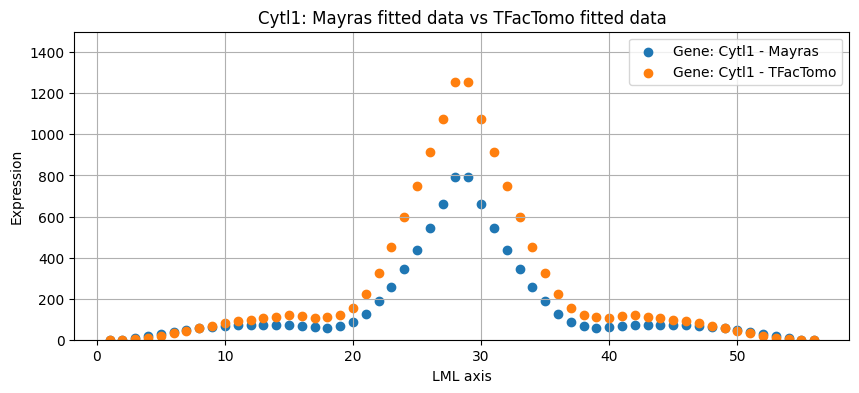

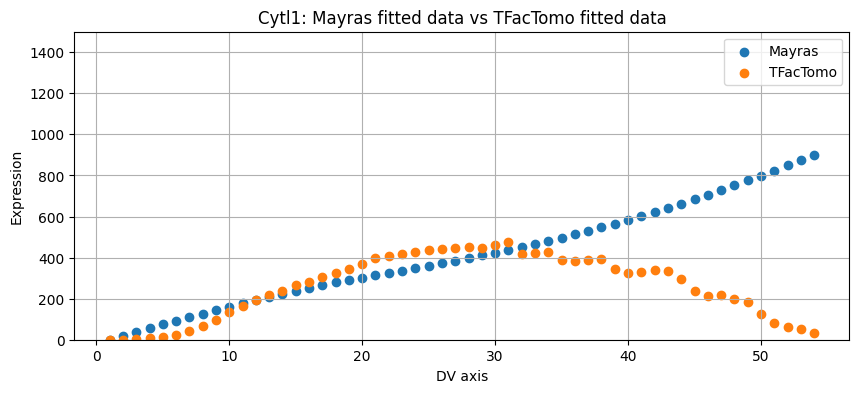

Shapes: (60,) (60,)
Mean scaling factor: 1.1801017996202448
Std of scaling factor: 0.3118606867974239


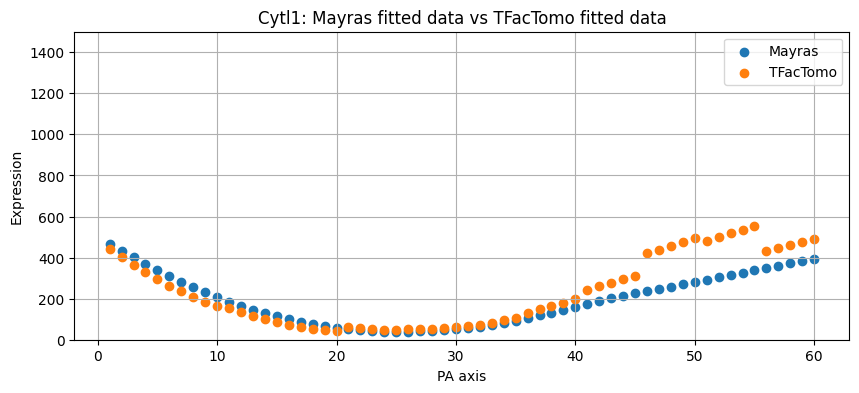

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [712]:
# comparing input data

# GENE: Cytl1

csv_profile = LML_axis_fitted.loc["Cytl1"].values.astype(float) # mayras data
npy_profile = X_y[9246].numpy() # from the TFacTomo paper

plt.figure(figsize=(10,4))
plt.scatter(x=lml_slices,y=csv_profile, label="Gene: Cytl1 - Mayras")
plt.scatter(x=lml_slices, y=npy_profile,  label="Gene: Cytl1 - TFacTomo")
plt.title("Cytl1: Mayras fitted data vs TFacTomo fitted data")
plt.xlabel("LML axis")
plt.ylabel("Expression")
plt.legend()
plt.ylim(0,1500)
plt.grid()
plt.show()

csv_profile = DV_axis_fitted.loc["Cytl1"].values.astype(float) # mayras data
npy_profile = X_x[9246].numpy() # from the TFacTomo paper

plt.figure(figsize=(10,4))
plt.scatter(x=dv_slices,y=csv_profile, label="Mayras")
plt.scatter(x=dv_slices,y=npy_profile, label="TFacTomo")
plt.title("Cytl1: Mayras fitted data vs TFacTomo fitted data")
plt.xlabel("DV axis")
plt.ylabel("Expression")
plt.legend()
plt.ylim(0,1500)
plt.grid()
plt.show()


csv_profile = PA_axis_fitted.loc["Cytl1"].values.astype(float) # mayras data
npy_profile = X_z[9246].numpy() # from the TFacTomo paper

print("Shapes:", csv_profile.shape, npy_profile.shape) # shape is matching !
scaling_factors = np.divide(npy_profile, csv_profile, where=csv_profile != 0) # find scaling factor
print("Mean scaling factor:", np.mean(scaling_factors)) #  TFacTomo data slightly larger
print("Std of scaling factor:", np.std(scaling_factors)) # high std means the scaling factor varies a lot


plt.figure(figsize=(10,4))
plt.scatter(x=ap_slices,y=csv_profile, label="Mayras")
plt.scatter(x=ap_slices, y=npy_profile, label="TFacTomo")
plt.title("Cytl1: Mayras fitted data vs TFacTomo fitted data")
plt.xlabel("PA axis")
plt.ylabel("Expression")
plt.ylim(0,1500)
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10,4))


IPF code, which reconstructs the tensor from 1D gene expression profiles. Below the code with step by step comments to understand properly how the algorithm works.

In [1004]:
import torch
import tensorly as tl

# brings slightly wrong results out...


# uses GPU if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tl.set_backend('pytorch')

# function to do the IPF reconstruct_modifiedion for a single gene !
def reconstruct_modified(X, M, max_epoch=1000, reduction='sum', normalized=True, verbose=True, freq=10):
    """
    IPF reconstruct_modifiedion for a single gene.
    
    Parameters:
    - X: list of [X_y, X_x, X_z], each of shape [1, n_y/x/z]
    - M: binary mask of shape [n_y, n_x, n_z]
    - max_epoch: number of IPF iterations
    - reduction: 'sum' or 'mean'
    - normalized: whether to normalize the input projections
    - verbose: whether to print residuals
    - freq: frequency of logging
    """

    # Unpack and extract shapes of the 1D projections of the gene expression: _, n_y = X_y.size(): torch.Size([1, 54]) --> _ = 1, n_y = 54, X_x.size() torch.Size([1, 56]), X_z.size(): torch.Size([1, 60])
    X_x, X_y, X_z = X  # X is the full tensor 
    _, n_y = X_y.size()
    _, n_x = X_x.size()
    _, n_z = X_z.size()


    # Sanity check: "assert" checks if the shape matches and raises an error if it does not !
    assert M.shape == (n_x, n_y, n_z), f"Expected M shape {(n_x, n_y, n_z)}, got {M.shape}"

    # normalize the projection if mode sum and normalization is true. This works: 
    if reduction == 'sum' and normalized:
        X_x = X_x / X_x.sum(dim=1, keepdim=True) * M.sum(dim=(1, 2))[None, :] # X_x.sum(dim=1, keepdim=True) : sum of all X_x  elements (1D projection along DV)
        X_y = X_y / X_y.sum(dim=1, keepdim=True) * M.sum(dim=(0, 2))[None, :]
        X_z = X_z / X_z.sum(dim=1, keepdim=True) * M.sum(dim=(0, 1))[None, :]


        # Replace NaNs with 0
        X_x[torch.isnan(X_x)] = 0
        X_y[torch.isnan(X_y)] = 0
        X_z[torch.isnan(X_z)] = 0
        """
        # Renormalize to same total mean
        mean = torch.mean(torch.stack((X_x.sum(), X_y.sum(), X_z.sum())))
        X_x = X_x / X_x.sum(dim=1)[:, None] * mean
        X_y = X_y / X_y.sum(dim=1)[:, None] * mean
        X_z = X_z / X_z.sum(dim=1)[:, None] * mean
        """
    # Create a single volume from M (shape [1, n_y, n_x, n_z])
    T = M.clone().unsqueeze(0).float()

    for epoch in range(1, max_epoch + 1):
        if reduction == 'sum':
            X_x_ = T.sum(dim=(2, 3))  # [1, n_x]
        else:
            X_x_ = T.mean(dim=(2, 3))
        T = T * (X_x / X_x_).view(1, n_x, 1, 1)
        T[torch.isnan(T)] = 0
        T[torch.isinf(T)] = 0

        if reduction == 'sum':
            X_y_ = T.sum(dim=(1, 3))  # [1, n_y]
        else:
            X_y_ = T.mean(dim=(1, 3))
        T = T * (X_y / X_y_).view(1, 1, n_y, 1)
        T[torch.isnan(T)] = 0
        T[torch.isinf(T)] = 0

        if reduction == 'sum':
            X_z_ = T.sum(dim=(1, 2))  # [1, n_z]
        else:
            X_z_ = T.mean(dim=(1, 2))
        T = T * (X_z / X_z_).view(1, 1, 1, n_z)
        T[torch.isnan(T)] = 0
        T[torch.isinf(T)] = 0

        if verbose and epoch % freq == 0:
            res = (
                torch.mean((T.sum(dim=(2, 3)) - X_x_) ** 2) +
                torch.mean((T.sum(dim=(1, 3)) - X_y_) ** 2) +
                torch.mean((T.sum(dim=(1, 2)) - X_z_) ** 2)
            )
            print(f"Training epoch: {epoch:03d}, Residual: {res:.10f}")

    return T


In [989]:
import torch
import tensorly as tl

# brings slightly wrong results out...


# uses GPU if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tl.set_backend('pytorch')

# function to do the IPF reconstruct_modifiedion for a single gene !
def reconstruct_modified_no_vol(X, M, max_epoch=1000, reduction='sum', normalized=True, verbose=True, freq=10):
    """
    IPF reconstruct_modifiedion for a single gene.
    
    Parameters:
    - X: list of [X_y, X_x, X_z], each of shape [1, n_y/x/z]
    - M: binary mask of shape [n_y, n_x, n_z]
    - max_epoch: number of IPF iterations
    - reduction: 'sum' or 'mean'
    - normalized: whether to normalize the input projections
    - verbose: whether to print residuals
    - freq: frequency of logging
    """

    # Unpack and extract shapes of the 1D projections of the gene expression: _, n_y = X_y.size(): torch.Size([1, 54]) --> _ = 1, n_y = 54, X_x.size() torch.Size([1, 56]), X_z.size(): torch.Size([1, 60])
    X_x, X_y, X_z = X  # X is the full tensor 
    _, n_y = X_y.size()
    _, n_x = X_x.size()
    _, n_z = X_z.size()


    # Sanity check: "assert" checks if the shape matches and raises an error if it does not !
    assert M.shape == (n_x, n_y, n_z), f"Expected M shape {(n_x, n_y, n_z)}, got {M.shape}"

    # normalize the projection if mode sum and normalization is true. This works: 
    if reduction == 'sum' and normalized:
        """     
        X_x = X_x / X_x.sum(dim=1, keepdim=True) * M.sum(dim=(1, 2))[None, :] # X_x.sum(dim=1, keepdim=True) : sum of all X_x  elements (1D projection along DV)
        X_y = X_y / X_y.sum(dim=1, keepdim=True) * M.sum(dim=(0, 2))[None, :]
        X_z = X_z / X_z.sum(dim=1, keepdim=True) * M.sum(dim=(0, 1))[None, :]
        """


        # Replace NaNs with 0
        X_x[torch.isnan(X_x)] = 0
        X_y[torch.isnan(X_y)] = 0
        X_z[torch.isnan(X_z)] = 0
        """
        # Renormalize to same total mean
        mean = torch.mean(torch.stack((X_x.sum(), X_y.sum(), X_z.sum())))
        X_x = X_x / X_x.sum(dim=1)[:, None] * mean
        X_y = X_y / X_y.sum(dim=1)[:, None] * mean
        X_z = X_z / X_z.sum(dim=1)[:, None] * mean
        """
    # Create a single volume from M (shape [1, n_y, n_x, n_z])
    T = M.clone().unsqueeze(0).float()

    for epoch in range(1, max_epoch + 1):
        if reduction == 'sum':
            X_x_ = T.sum(dim=(2, 3))  # [1, n_x]
        else:
            X_x_ = T.mean(dim=(2, 3))
        T = T * (X_x / X_x_).view(1, n_x, 1, 1)
        T[torch.isnan(T)] = 0
        T[torch.isinf(T)] = 0

        if reduction == 'sum':
            X_y_ = T.sum(dim=(1, 3))  # [1, n_y]
        else:
            X_y_ = T.mean(dim=(1, 3))
        T = T * (X_y / X_y_).view(1, 1, n_y, 1)
        T[torch.isnan(T)] = 0
        T[torch.isinf(T)] = 0

        if reduction == 'sum':
            X_z_ = T.sum(dim=(1, 2))  # [1, n_z]
        else:
            X_z_ = T.mean(dim=(1, 2))
        T = T * (X_z / X_z_).view(1, 1, 1, n_z)
        T[torch.isnan(T)] = 0
        T[torch.isinf(T)] = 0

        if verbose and epoch % freq == 0:
            res = (
                torch.mean((T.sum(dim=(2, 3)) - X_x_) ** 2) +
                torch.mean((T.sum(dim=(1, 3)) - X_y_) ** 2) +
                torch.mean((T.sum(dim=(1, 2)) - X_z_) ** 2)
            )
            print(f"Training epoch: {epoch:03d}, Residual: {res:.10f}")

    return T


In [872]:
print('X_x:', X_x.shape)
print('X_y:', X_y.shape)
print('X_z:', X_z.shape)
print('M.shape', M.shape)

X_x: torch.Size([9254, 54])
X_y: torch.Size([9254, 56])
X_z: torch.Size([9254, 60])
M.shape torch.Size([54, 56, 60])


Using the modified ipf reconstruction function for only a single gene. Here as the testing gene "Cytl1" is used.

In [ ]:
''' 
Reminder:

X_x = DV data --> size: 9254 x 54
X_y = LML data --> size: 9254 x 56
X_z = PA data --> size: 9254 x 60
'''

gene_name = "Cytl1"
gene_idx = np.where(genes == gene_name)[0][0]  

X_y_single = X_y[gene_idx].unsqueeze(0)  
X_x_single = X_x[gene_idx].unsqueeze(0)  
X_z_single = X_z[gene_idx].unsqueeze(0)


T = reconstruct_modified([X_x_single, X_y_single, X_z_single], M, max_epoch=1000, reduction="sum", normalized=True, verbose=True)


T_ipf_modified = T[0].cpu().numpy()  # final 3D tensor for visualization


Here below is the IPF package from the authors...

In [633]:
'''# using the reconstruct function from IPF # does not work?!

from IPF import reconstruct


T_ipf_orig = reconstruct([X_x, X_y, X_z], M, max_epoch=500, reduction="sum", normalized=True, verbose=True)
T_ipf_original = T_ipf_orig[0].cpu().numpy()
'''

len(M.sum(dim=(0, 2)))#[None, :]

56

In [ ]:
'''# using self defined ipf reconsturction now ---> normalization changed here 

X = [X_x_single, X_y_single, X_z_single]

T = reconstruct(X, M, max_epoch=500, reduction="sum", normalized=True, verbose=True)
T = T[0].cpu().numpy()
'''

In [991]:
# MASK


mask_tensor.shape
mask_tensor = torch.from_numpy(mask_tensor).float()  


Using the IPF from TFacTomo with Mayras data

In [1005]:
import torch


t_DV = torch.from_numpy(target_DV_no_volume).float()
t_LML = torch.from_numpy(target_LML_no_volume).float()
t_PA = torch.from_numpy(target_PA_no_volume).float()

# 2) If you just need a single row of length 54 (i.e. shape (1, 54)), do:
t_DV = t_DV.unsqueeze(0)
t_LML = t_LML.unsqueeze(0)
t_PA = t_PA.unsqueeze(0)

T_mayra = reconstruct_modified([t_DV, t_LML, t_PA], mask_tensor, max_epoch=1000, reduction="sum", normalized=True, verbose=True)
proj_3d_tfactomo = T_mayra[0].cpu().numpy()


T_mayra_no_vol = reconstruct_modified_no_vol([t_DV, t_LML, t_PA], mask_tensor, max_epoch=1000, reduction="sum", normalized=True, verbose=True)
proj_3d_no_vol = T_mayra_no_vol[0].cpu().numpy()


Training epoch: 010, Residual: 99.1717224121
Training epoch: 020, Residual: 99.1723632812
Training epoch: 030, Residual: 99.1723098755
Training epoch: 040, Residual: 99.1723480225
Training epoch: 050, Residual: 99.1723632812
Training epoch: 060, Residual: 99.1723480225
Training epoch: 070, Residual: 99.1723861694
Training epoch: 080, Residual: 99.1723632812
Training epoch: 090, Residual: 99.1723403931
Training epoch: 100, Residual: 99.1723556519
Training epoch: 110, Residual: 99.1723556519
Training epoch: 120, Residual: 99.1723709106
Training epoch: 130, Residual: 99.1723556519
Training epoch: 140, Residual: 99.1723480225
Training epoch: 150, Residual: 99.1723251343
Training epoch: 160, Residual: 99.1723632812
Training epoch: 170, Residual: 99.1723785400
Training epoch: 180, Residual: 99.1723403931
Training epoch: 190, Residual: 99.1723556519
Training epoch: 200, Residual: 99.1723632812
Training epoch: 210, Residual: 99.1723327637
Training epoch: 220, Residual: 99.1723327637
Training e

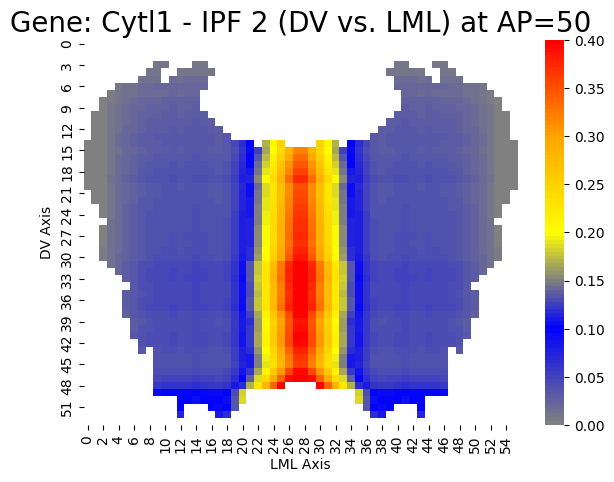

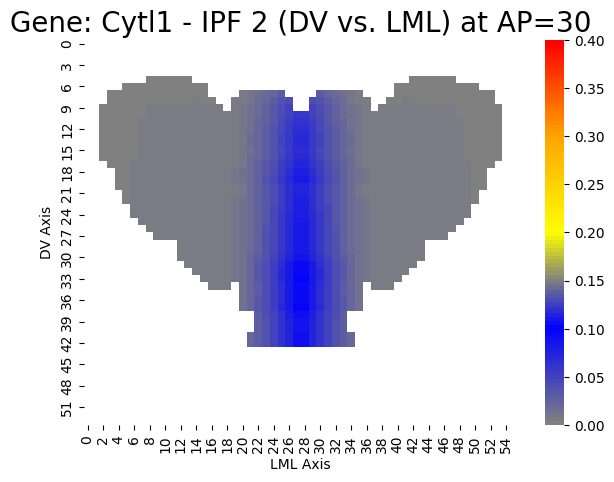

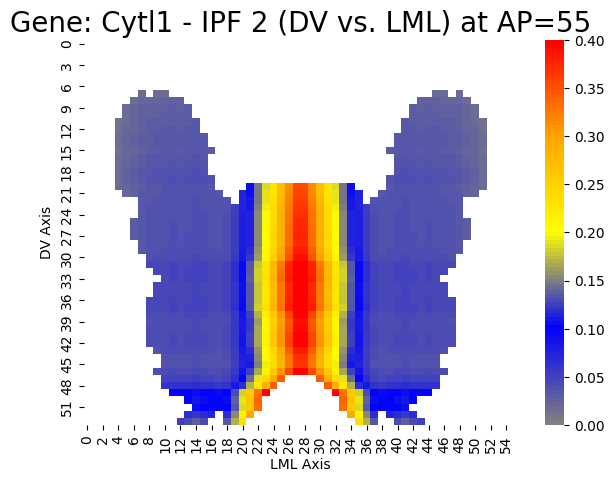

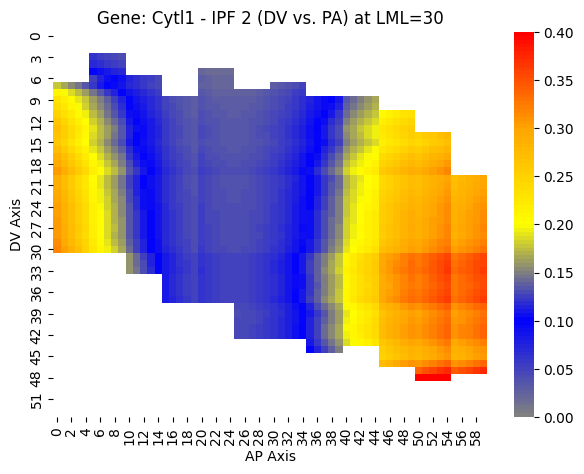

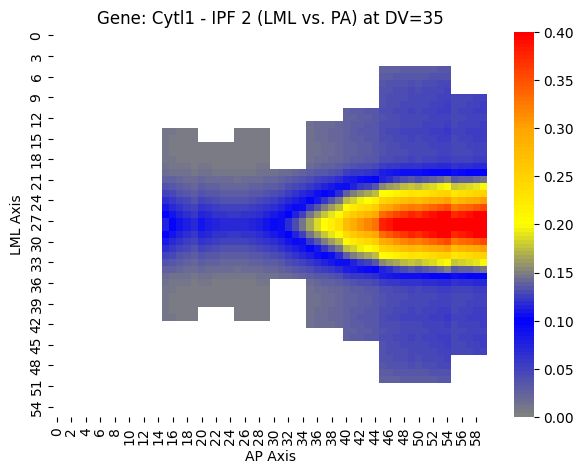

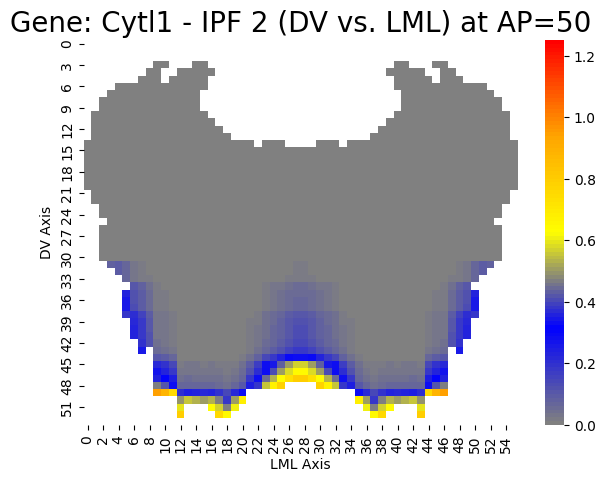

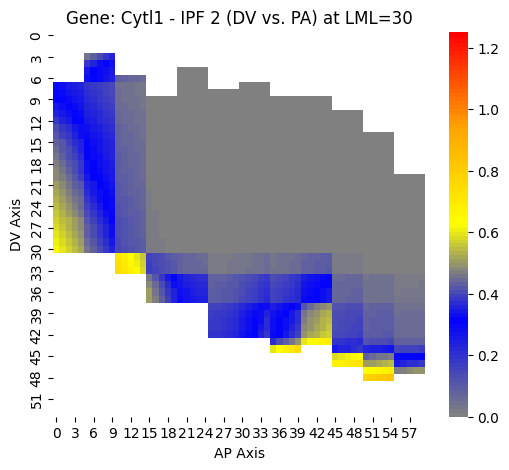

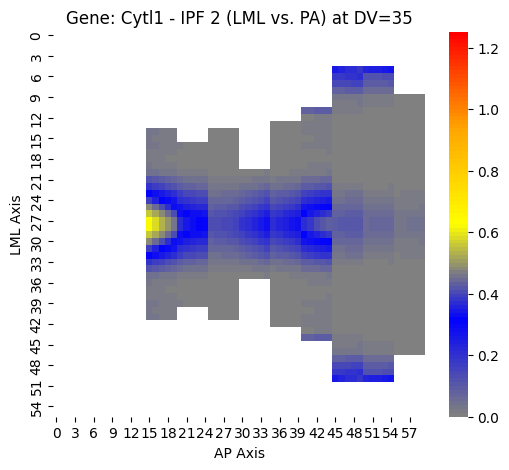

In [1007]:


"""# ---------------------------- Calculate average gene count ---------------------------- #
# Use normalized expression (not fitted) to reflect actual counts
av_gene_counts = np.mean([
    np.sum(PA_axis_norm.loc[gene_cytl1].values),
    np.sum(DV_axis_norm.loc[gene_cytl1].values),
    np.sum(LML_axis_norm.loc[gene_cytl1].values)
])"""



from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)


M = mask_tensor
# ---------------------------- Step 4: Log-transform expression ---------------------------- #
#proj_tfactomo = T_mayra # Add +1 to avoid log(0)
proj_scaled_tfactomo = proj_3d_tfactomo * (av_gene_counts / proj_3d_tfactomo.sum())
proj_tfactomo    = np.log10(proj_scaled_tfactomo + 1)

# ---------------------------- Step 5: Visualize 2D slices with mask overlay ---------------------------- #
white_cmap = ListedColormap(["white"])

# Slice along PA axis
slice_idx = 50
pa_slice = proj_tfactomo[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.4, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along PA axis
slice_idx = 30
pa_slice = proj_tfactomo[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.4, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along PA axis
slice_idx = 55
pa_slice = proj_tfactomo[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.4, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = proj_tfactomo[:, slice_idx, :]
mask_lml_slice = M[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(lml_slice, cmap=r_palette,vmin=0, vmax=0.4, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (DV vs. PA) at LML={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 35
dv_slice = proj_tfactomo[slice_idx, :, :]
mask_dv_slice = M[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(dv_slice, cmap=r_palette,vmin=0, vmax=0.4, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (LML vs. PA) at DV={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()


#### no volume normalization before input to IPF algorithm ####


proj_tfactomo_no_vol = proj_3d_no_vol * (av_gene_counts / proj_3d_no_vol.sum())
proj_tfactomo_no_vol_norm = np.log10(proj_tfactomo_no_vol + 1)

# ---------------------------- Step 5: Visualize 2D slices with mask overlay ---------------------------- #
white_cmap = ListedColormap(["white"])

# Slice along PA axis
slice_idx = 50
pa_slice = proj_tfactomo_no_vol_norm[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=proj_tfactomo_no_vol_norm.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = proj_tfactomo_no_vol_norm[:, slice_idx, :]
mask_lml_slice = M[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(lml_slice, cmap=r_palette,vmin=0, vmax=proj_tfactomo_no_vol_norm.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (DV vs. PA) at LML={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 35
dv_slice = proj_tfactomo_no_vol_norm[slice_idx, :, :]
mask_dv_slice = M[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(dv_slice, cmap=r_palette,vmin=0, vmax=proj_tfactomo_no_vol_norm.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - IPF 2 (LML vs. PA) at DV={slice_idx}")
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()



In [1045]:
# you have to rescale the input data such that te IPF results are comparable

t_DV_nv  = target_DV_no_volume   # Länge n_x
t_LML_nv = target_LML_no_volume  # Länge n_y
t_PA_nv  = target_PA_no_volume   # Länge n_z

# 2) IPF2‐interne „erste Normalisierung“ (ohne den späteren mean‐Block):
X_x_initial = (t_DV_nv / t_DV_nv.sum()) * volume_DV
X_y_initial = (t_LML_nv / t_LML_nv.sum()) * volume_LML
X_z_initial = (t_PA_nv / t_PA_nv.sum()) * volume_PA

# 3) Summen jeder Achse
sum_x = X_x_initial.sum()
sum_y = X_y_initial.sum()
sum_z = X_z_initial.sum()

# 4) Mittelwert der drei Summen
mean_all = (sum_x + sum_y + sum_z) / 3


X_x_target = X_x_initial * (mean_all / sum_x)    # Länge n_x
X_y_target = X_y_initial * (mean_all / sum_y)    # Länge n_y
X_z_target = X_z_initial * (mean_all / sum_z)    # Länge n_z

# Evaluation of IPF 1 (Mayras IPF)

# IPF Reconstruction
ipf_sum_x = proj_3d_tfactomo.sum(axis=(1, 2))
ipf_sum_y = proj_3d_tfactomo.sum(axis=(0, 2))
ipf_sum_z = proj_3d_tfactomo.sum(axis=(0, 1))

# DV-axis
mse_DV_IPF2, map_DV_IPF2, corr_DV_IPF2 = evaluation(ipf_sum_x, X_x_target)

# LML-axis
mse_LML_IPF2, map_LML_IPF2, corr_LML_IPF2 = evaluation(ipf_sum_y, X_y_target)

# AP-axis
mse_AP_IPF2, map_AP_IPF2, corr_AP_IPF2 = evaluation(ipf_sum_z, X_z_target)

print('IPF2:')
print(f'mse DV: {mse_DV_IPF2}, mse LML: {mse_LML_IPF2}, mse AP: {mse_AP_IPF2}')
print(f'map LML: {map_DV_IPF2}, map LML: {map_LML_IPF2}, map AP: {map_AP_IPF2}')
print(f'corr DV: {corr_DV_IPF2}, corr LML: {corr_LML_IPF2}, corr AP: {corr_AP_IPF2}')



IPF2:
mse DV: 7.360792576567108, mse LML: 15.21285387154746, mse AP: 7.3622427640055115
map LML: 2.3482127970580047, map LML: 2.26434749657676, map AP: 2.113391921670378
corr DV: 0.9999999999999853, corr LML: 0.9999999999999796, corr AP: 0.9999999999995653


In [1046]:
# you have to rescale the input data such that te IPF results are comparable

t_DV_nv  = target_DV_no_volume   # Länge n_x
t_LML_nv = target_LML_no_volume  # Länge n_y
t_PA_nv  = target_PA_no_volume   # Länge n_z

# Evaluation of IPF 1 (Mayras IPF)

# IPF Reconstruction
ipf_sum_x = proj_3d_no_vol.sum(axis=(1, 2))
ipf_sum_y = proj_3d_no_vol.sum(axis=(0, 2))
ipf_sum_z = proj_3d_no_vol.sum(axis=(0, 1))

# DV-axis
mse_DV_IPF2, map_DV_IPF2, corr_DV_IPF2 = evaluation(ipf_sum_x, t_DV_nv)

# LML-axis
mse_LML_IPF2, map_LML_IPF2, corr_LML_IPF2 = evaluation(ipf_sum_y, t_LML_nv)

# AP-axis
mse_AP_IPF2, map_AP_IPF2, corr_AP_IPF2 = evaluation(ipf_sum_z, t_PA_nv)

print('IPF2:')
print(f'mse DV: {mse_DV_IPF2}, mse LML: {mse_LML_IPF2}, mse AP: {mse_AP_IPF2}')
print(f'map LML: {map_DV_IPF2}, map LML: {map_LML_IPF2}, map AP: {map_AP_IPF2}')
print(f'corr DV: {corr_DV_IPF2}, corr LML: {corr_LML_IPF2}, corr AP: {corr_AP_IPF2}')



IPF2:
mse DV: 54056.27070505784, mse LML: 7077.083617153987, mse AP: 5.052399810378522e-09
map LML: 200.34158994883364, map LML: 51.110028978072414, map AP: 3.990799688011748e-05
corr DV: 0.9999999999999928, corr LML: 0.9999999999999868, corr AP: 0.9999999999998386


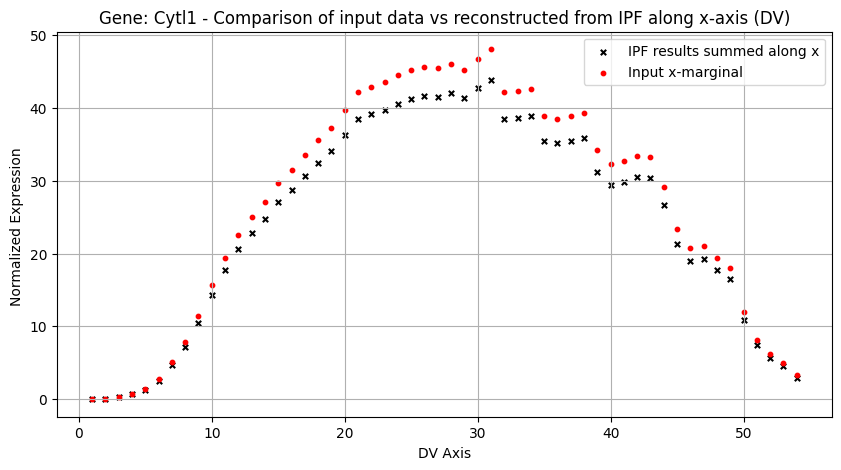

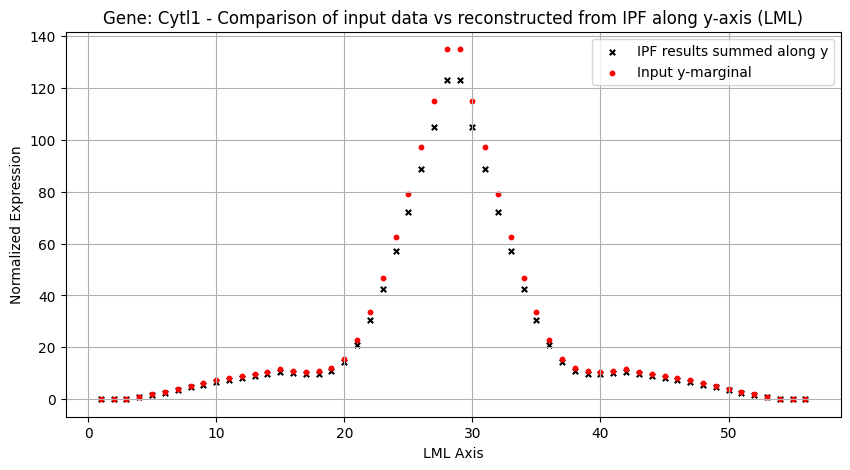

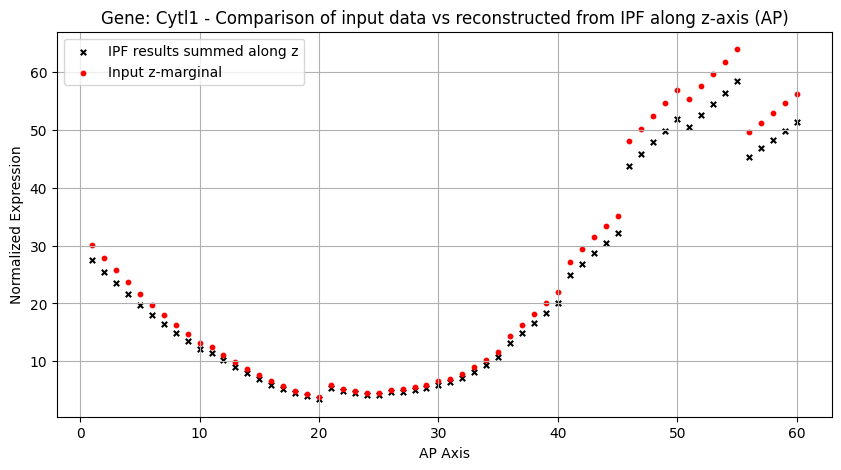

In [886]:

# using the modified ipf function from the TFacTomo authors for the data of Mayra

''' 
Reminder:

X_x = DV data --> size: 9254 x 54
X_y = LML data --> size: 9254 x 56
X_z = PA data --> size: 9254 x 60
'''



# draw results

x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, ipf_sum_x, s=15, c='k', marker='x',label= 'IPF results summed along x')
plt.scatter(x, X_x_target, s=10, c='red', label='Input x-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along x-axis (DV)")
plt.xlabel("DV Axis")
plt.ylabel("Normalized Expression ")
plt.legend()
plt.grid()
plt.show()

y = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(y, ipf_sum_y, s=15, c='k',marker='x',label= 'IPF results summed along y')
plt.scatter(y, X_y_target, s=10, c='red', label='Input y-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along y-axis (LML)")
plt.xlabel("LML Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

z = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(z, ipf_sum_z, s=15, marker='x', c='k', label= 'IPF results summed along z')
plt.scatter(z, X_z_target, s=10, c='red', label='Input z-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from IPF along z-axis (AP)")
plt.xlabel("AP Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()


In [827]:
 print('proj_3d_tfactomo:',proj_3d_tfactomo.shape)
 print('mayra:',proj_mayra.shape)

proj_3d_tfactomo: (54, 56, 60)
mayra: (54, 56, 60)


In [166]:
'''# changing IPF ---> # using self defined ipf reconsturction now ---> normalization changed here 

# brings slightly wrong results out...

import os
import gc
import torch
import numpy as np
import tensorly as tl
from functools import reduce

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tl.set_backend('pytorch')


def reconstruct(X, M, max_epoch=201, reduction='sum', normalized=True, verbose=True, freq=10):
    
    X_x = X[0]; X_y = X[1]; X_z = X[2]
    n_g, n_x = X_x.size(); n_y = X_y.size()[1]; n_z = X_z.size()[1]
    
    if reduction=='sum' and normalized:
        X_x = X_x / X_x.sum(dim=1,keepdim=True) * M.sum(dim=(1,2))[None, :]
        X_y = X_y / X_y.sum(dim=1,keepdim=True) * M.sum(dim=(0,2))[None, :]
        X_z = X_z / X_z.sum(dim=1,keepdim=True) * M.sum(dim=(0,1))[None, :]

        # don’t forget this next bit:
        mean = torch.mean(torch.stack((X_x.sum(), X_y.sum(), X_z.sum())))
        X_x  = X_x / X_x.sum(dim=1,keepdim=True) * mean
        X_y  = X_y / X_y.sum(dim=1,keepdim=True) * mean
        X_z  = X_z / X_z.sum(dim=1,keepdim=True) * mean
        
        mean = torch.mean(torch.stack((X_x.sum(), X_y.sum(), X_z.sum())))
        
        X_x = X_x / X_x.sum(dim=1)[:, None] * mean
        X_y = X_y / X_y.sum(dim=1)[:, None] * mean
        X_z = X_z / X_z.sum(dim=1)[:, None] * mean
        
    T = M.repeat(n_g, 1, 1, 1)
    
    for epoch in range(1, max_epoch):
        
        if reduction == 'sum':
            X_x_ = T.sum(dim=(2, 3))
        else:
            X_x_ = T.mean(dim=(2, 3))
        T = T * torch.permute((X_x/X_x_).repeat(n_y, n_z, 1, 1), (2, 3, 0, 1))
        T[torch.where(torch.isnan(T))] = 0; T[torch.where(torch.isinf(T))] = 0
        
        if reduction == 'sum':
            X_y_ = T.sum(dim=(1, 3))
        else:
            X_y_ = T.mean(dim=(1, 3))
        T = T * torch.permute((X_y/X_y_).repeat(n_x, n_z, 1, 1), (2, 0, 3, 1))
        T[torch.where(torch.isnan(T))] = 0; T[torch.where(torch.isinf(T))] = 0
        
        if reduction == 'sum':
            X_z_ = T.sum(dim=(1, 2))
        else:
            X_z_ = T.mean(dim=(1, 2))
        T = T * torch.permute((X_z/X_z_).repeat(n_x, n_y, 1, 1), (2, 0, 1, 3))
        T[torch.where(torch.isnan(T))] = 0; T[torch.where(torch.isinf(T))] = 0
        
        if verbose and epoch % freq == 0:
            if reduction == 'sum':
                res = torch.mean((T.sum(dim=(2, 3)) - X_x) ** 2) + torch.mean((T.sum(dim=(1, 3)) - X_y) ** 2) + torch.mean((T.sum(dim=(1, 2)) - X_z) ** 2)
            else:
                res = torch.mean((T.mean(dim=(2, 3)) - X_x) ** 2) + torch.mean((T.mean(dim=(1, 3)) - X_y) ** 2) + torch.mean((T.mean(dim=(1, 2)) - X_z) ** 2)
#         res = torch.mean((T-T_)**2)
            print(f'Training epoch: {epoch:02d}, Residual: {res:.10f}')
    
    return T'''

Testing modified IPF algorithm for the same input data as above (target_DV, target_LML, target_PA)

In [529]:
import torch
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import cp_to_tensor

# use the NumPy backend
tl.set_backend('numpy')


A = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/mouse_olfactory_mucosa_CPD_factors.pt")

# 1b) move to NumPy and build the full tensor
factors = [a.cpu().numpy() for a in A]
full4d  = cp_to_tensor((None, factors))   # shape (n_genes, n_y, n_x, n_z)

# 1c) pick one gene
g_idx    = np.where(genes=="Cytl1")[0][0]
seed3d   = full4d[g_idx]                 # shape (n_y, n_x, n_z)

# 1d) load your mask
mask3d = M.cpu().numpy() 
seed3d  *= mask3d


In [911]:
from IPF import reconstruct


X_y = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_lml_data.npy")[g_idx]  
X_x = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_dv_data.npy")[g_idx]   
X_z = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_ap_data.npy")[g_idx]   

X_x_t = torch.from_numpy(X_x).float().unsqueeze(0)  # [1,54]
X_y_t = torch.from_numpy(X_y).float().unsqueeze(0)  # [1,56]
X_z_t = torch.from_numpy(X_z).float().unsqueeze(0)  # [1,60]

print('X_x_t:', X_x_t.shape)
print('X_y_t:', X_y_t.shape)
print('X_z_t:', X_z_t.shape)
print('M:', M.shape)


X_x_t: torch.Size([1, 54])
X_y_t: torch.Size([1, 56])
X_z_t: torch.Size([1, 60])
M: torch.Size([54, 56, 60])


In [912]:
X_x_vol = X_x/volume_DV.sum()
X_y_vol = X_y/volume_LML.sum()
X_z_vol = X_z/volume_PA.sum()

X_x_vol_norm = torch.from_numpy(X_x_vol).float().unsqueeze(0)
X_y_vol_norm = torch.from_numpy(X_y_vol).float().unsqueeze(0)
X_z_vol_norm = torch.from_numpy(X_z_vol).float().unsqueeze(0)


In [913]:

T_TFacTomo_IPF = reconstruct_modified([X_x_t, X_y_t, X_z_t], mask_tensor, max_epoch=1000, reduction="sum", normalized=True, verbose=True)
proj_ipf_tfactomo = T_TFacTomo_IPF[0].cpu().numpy()



Training epoch: 010, Residual: 164.7891082764
Training epoch: 020, Residual: 164.7891387939
Training epoch: 030, Residual: 164.7891845703
Training epoch: 040, Residual: 164.7892303467
Training epoch: 050, Residual: 164.7891998291
Training epoch: 060, Residual: 164.7892303467
Training epoch: 070, Residual: 164.7892761230
Training epoch: 080, Residual: 164.7893066406
Training epoch: 090, Residual: 164.7892456055
Training epoch: 100, Residual: 164.7893218994
Training epoch: 110, Residual: 164.7892456055
Training epoch: 120, Residual: 164.7892761230
Training epoch: 130, Residual: 164.7892150879
Training epoch: 140, Residual: 164.7892456055
Training epoch: 150, Residual: 164.7892761230
Training epoch: 160, Residual: 164.7892608643
Training epoch: 170, Residual: 164.7892150879
Training epoch: 180, Residual: 164.7892456055
Training epoch: 190, Residual: 164.7892303467
Training epoch: 200, Residual: 164.7892456055
Training epoch: 210, Residual: 164.7892608643
Training epoch: 220, Residual: 164

In [914]:
T_TFacTomo_vol = reconstruct_modified([X_x_vol_norm, X_y_vol_norm, X_z_vol_norm], mask_tensor, max_epoch=1000, reduction="sum", normalized=True, verbose=True)
proj_ipf_tfactomo_vol = T_TFacTomo_vol[0].cpu().numpy()

Training epoch: 010, Residual: 164.7890625000
Training epoch: 020, Residual: 164.7891845703
Training epoch: 030, Residual: 164.7891235352
Training epoch: 040, Residual: 164.7891540527
Training epoch: 050, Residual: 164.7891998291
Training epoch: 060, Residual: 164.7891845703
Training epoch: 070, Residual: 164.7891845703
Training epoch: 080, Residual: 164.7891845703
Training epoch: 090, Residual: 164.7891540527
Training epoch: 100, Residual: 164.7891845703
Training epoch: 110, Residual: 164.7891998291
Training epoch: 120, Residual: 164.7892150879
Training epoch: 130, Residual: 164.7890777588
Training epoch: 140, Residual: 164.7891845703
Training epoch: 150, Residual: 164.7891387939
Training epoch: 160, Residual: 164.7891235352
Training epoch: 170, Residual: 164.7890777588
Training epoch: 180, Residual: 164.7890930176
Training epoch: 190, Residual: 164.7891693115
Training epoch: 200, Residual: 164.7891998291
Training epoch: 210, Residual: 164.7891845703
Training epoch: 220, Residual: 164

In [915]:
#vol = np.log10(vol +1)
mask_tensor

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

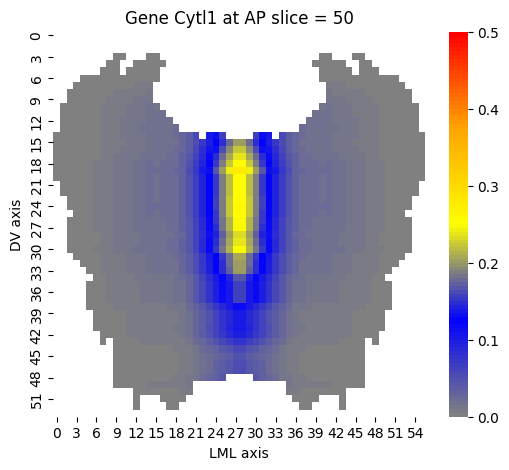

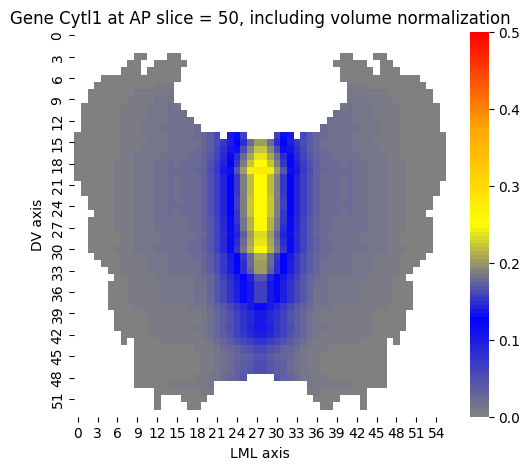

In [916]:
# this reconstructs just IPF....


from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)

M = mask_tensor

'''proj_3d_tfactomo = T_TFacTomo # Add +1 to avoid log(0)
proj_scaled = proj_3d_tfactomo * (av_gene_counts / proj_3d_tfactomo.sum())
proj_3d     = np.log10(proj_scaled + 1)'''

white_cmap = ListedColormap(["white"])
slice_idx = 50  # e.g. AP slice

pa_slice     = proj_ipf_tfactomo[:, :, slice_idx]
mask_slice   = M[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(6,5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.5)
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene Cytl1 at AP slice = {slice_idx}")
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()


# with volume normalization


pa_slice     = proj_ipf_tfactomo_vol[:, :, slice_idx]
mask_slice   = M[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(6,5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.5)
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene Cytl1 at AP slice = {slice_idx}, including volume normalization")
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()



TFacTOMO results !!!!

In [197]:
import numpy as np
import tensorly as tl

tl.set_backend('numpy')    

# full paths or relative to your working directory

base = "/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results"

A_g = np.load(f"{base}/A_g_fixed1.npy")     # shape = (n_genes,   rank)
A_x = np.load(f"{base}/A_x_fixed1.npy")     # shape = (n_DV,      rank)
A_y = np.load(f"{base}/A_y_fixed1.npy")     # shape = (n_LML,     rank)
A_z = np.load(f"{base}/A_z_fixed1.npy")     # shape = (n_AP,      rank)

print("shapes:", A_g.shape, A_x.shape, A_y.shape, A_z.shape)

M = np.load('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy')

base_2 = "/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/TFacTomo/shiny_app/vis_OM/tensor_model"
 
A_g_old = np.load(f"{base_2}/A_g.npy")     # shape = (n_genes,   rank)
A_x_old = np.load(f"{base_2}/A_x.npy")     # shape = (n_DV,      rank)
A_y_old = np.load(f"{base_2}/A_y.npy")     # shape = (n_LML,     rank)
A_z_old = np.load(f"{base_2}/A_z.npy")     # shape = (n_AP,      rank)


shapes: (9254, 500) (54, 500) (56, 500) (60, 500)


In [198]:
M.shape

(54, 56, 60)

In [199]:
vol3d.shape

(54, 56, 60)

In [200]:
assert A_g.shape[1] == A_x.shape[1] == A_y.shape[1] == A_z.shape[1]


A_x.shape[0] == 54
A_y.shape[0] == 56
A_z.shape[0] == 60


# whole tensor 

factors = [A_g, A_x, A_y, A_z]
T_all   = tl.cp_tensor.cp_to_tensor((None, factors))
#T_all.shape == (n_genes, 54, 56, 60)


factors_old = [A_g_old, A_x_old, A_y_old, A_z_old]
T_all_old   = tl.cp_tensor.cp_to_tensor((None, factors_old))
#T_all.shape == (n_genes, 54, 56, 60)



In [270]:

proj_3d_tfactomo = T_TFacTomo # Add +1 to avoid log(0)
proj_scaled = proj_3d_tfactomo * (av_gene_counts / proj_3d_tfactomo.sum())
proj_3d     = np.log10(proj_scaled + 1)

array([[5.1771934e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 5.1771934e-08],
       [1.5531579e-07, 5.1771934e-08, 0.0000000e+00, ..., 5.1771934e-08,
        5.1771934e-08, 2.0708769e-07],
       [4.1417530e-07, 1.0354386e-07, 0.0000000e+00, ..., 1.0354386e-07,
        5.1771934e-08, 5.6949091e-07],
       ...,
       [5.1771934e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 5.1771934e-08],
       [1.5531579e-07, 5.1771934e-08, 0.0000000e+00, ..., 5.1771934e-08,
        0.0000000e+00, 1.5531579e-07],
       [1.0354386e-07, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0354386e-07]], dtype=float32)

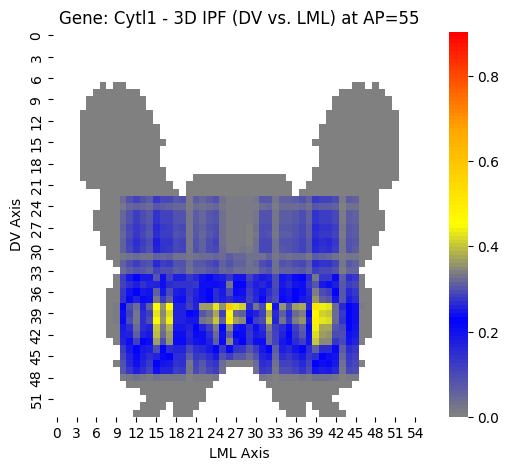

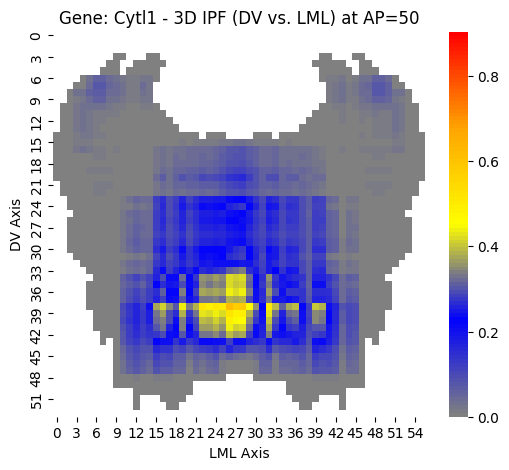

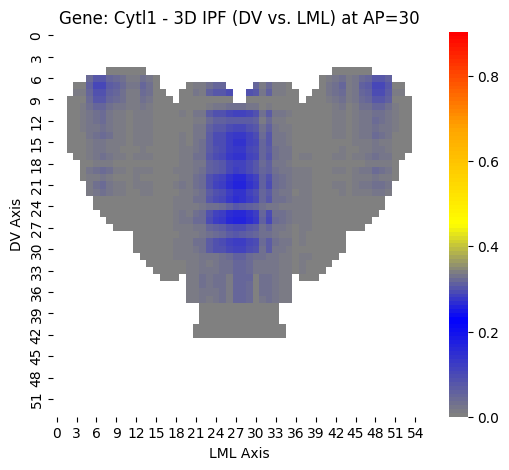

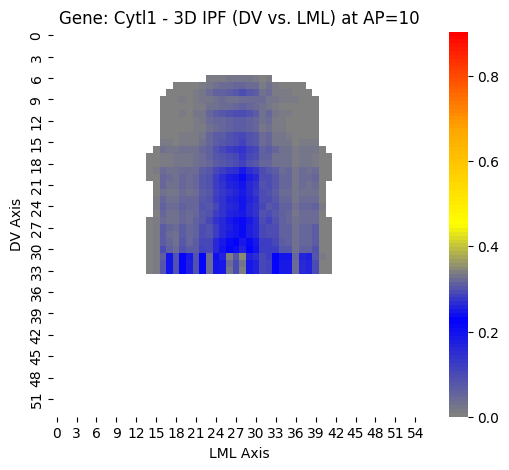

In [201]:
"""# 1) load your CP factors A = [A_g, A_x, A_y, A_z]
A = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/mouse_olfactory_mucosa_CPD_factors_fixed1.pt")
# make sure tensorly uses numpy backend
tl.set_backend('numpy')
"""

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)

# 3) pick your gene and extract its 3-D volume
gene_name = "Cytl1"
g = np.where(genes == gene_name)[0][0]
vol3d = T_all[g]         # shape (n_DV, n_LML, n_AP)

#proj_scaled = vol3d * (av_gene_counts / vol3d.sum())
#vol3d     = np.log10(proj_scaled + 1)

vol3d = np.log10(vol3d + 1)
# 5) load your tissue mask (same dimensions as vol3d)

white_cmap = ListedColormap(["white"])
slice_idx = 55  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=vol3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 50  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=vol3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 30  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 10  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()



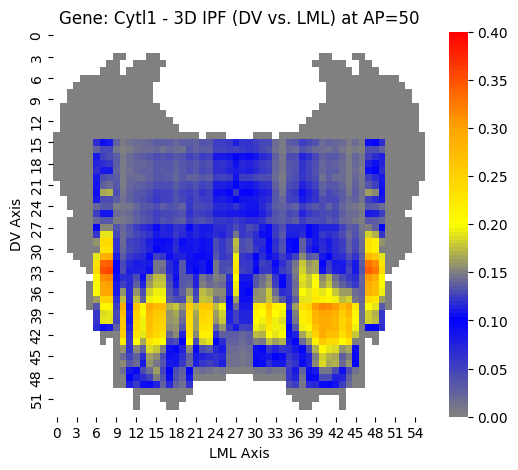

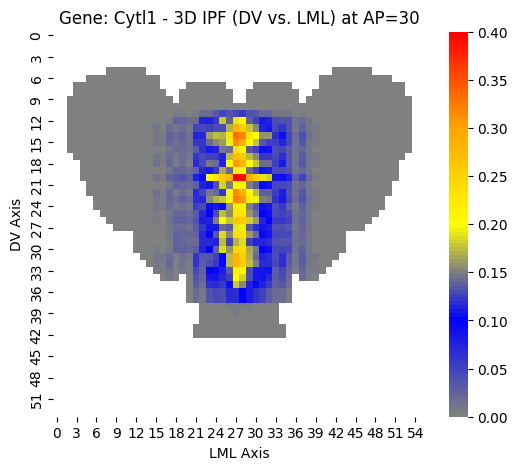

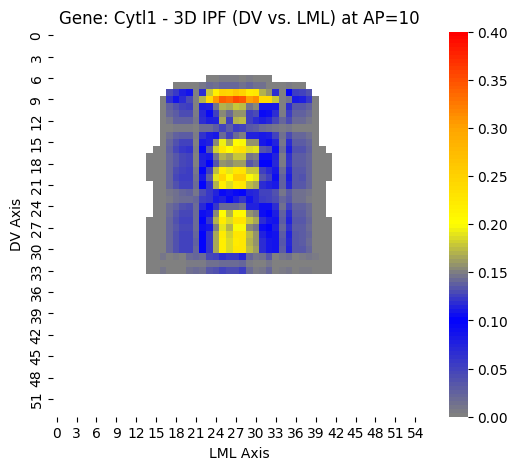

In [232]:
# old approach


"""# 1) load your CP factors A = [A_g, A_x, A_y, A_z]
A = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/mouse_olfactory_mucosa_CPD_factors_fixed1.pt")
# make sure tensorly uses numpy backend
tl.set_backend('numpy')
"""

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)

# 3) pick your gene and extract its 3-D volume
gene_name = "Cytl1"
g = np.where(genes == gene_name)[0][0]
vol3d = T_all_old[g]         # shape (n_DV, n_LML, n_AP)

vol3d = np.log10(vol3d +1)

#vol3d = np.log10(vol3d + 1)
# 5) load your tissue mask (same dimensions as vol3d)
mask = M

white_cmap = ListedColormap(["white"])
slice_idx = 50  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.4,annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=0.4,annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 10  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(6, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=0.4, annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - 3D IPF (DV vs. LML) at AP={slice_idx}")
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()



In [971]:
# new test # ----> newest

import numpy as np
import torch
import tensorly as tl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# 1) Load your CP factors (the A lists you saved)
factors = torch.load(
    "/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/"
    "TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/"
    "mouse_olfactory_mucosa_CPD_factors.pt"
)
# Convert each to a NumPy array
A = [a.cpu().numpy() for a in factors]

# 2) Reconstruct the full gene×X×Y×Z tensor
tl.set_backend("numpy")
T_all = tl.cp_tensor.cp_to_tensor((None, A))
# Now T_all.shape == (n_genes, dim_x, dim_y, dim_z)

# 3) Load your 3D mask for overlay
mask = np.load(
    "/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/"
    "TFacTomo_OM_data/data/mouse_olfactory_mucosa/"
    "mouse_olfactory_mucosa_mask.npy"
)


In [77]:
A # A_g, A_x, A_y, A_z

factors

[tensor([[0.0000e+00, 1.4013e-45, 1.4013e-45,  ..., 9.8091e-45, 0.0000e+00,
          1.5256e-32],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.2965e-29, 1.0816e-22, 3.0545e-16,  ..., 1.4965e-10, 0.0000e+00,
          9.5550e-05],
         ...,
         [2.8026e-45, 2.8026e-45, 1.4013e-45,  ..., 1.4013e-45, 2.6548e-32,
          6.4389e-06],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.4013e-45,  ..., 1.4013e-45, 0.0000e+00,
          8.7539e-06]]),
 tensor([[2.6633e-01, 8.6354e-02, 1.6126e-01,  ..., 3.3508e-02, 2.5573e-10,
          9.9660e-10],
         [4.2187e-01, 7.1359e-02, 3.4451e-01,  ..., 2.2326e-02, 1.5287e-10,
          1.2869e-08],
         [4.8115e-02, 5.9855e-01, 1.5594e-01,  ..., 7.2943e-03, 1.6038e-11,
          4.5387e-07],
         ...,
         [1.2938e-03, 9.2789e-01, 4.2074e-03,  ..., 7.6889e-04, 7.9890e-06,
   

In [71]:
genes[9246]

'Cytl1'

In [64]:
gene_name = "Cytl1"
gidx = np.where(genes == gene_name)[0][0]

vol3d = T_all[gidx]    # shape (dim_x, dim_y, dim_z)


Using Mayras data to do the IPF reconstruction of FTacTomo


In [972]:
W_x_mayra

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [963]:
target_DV

array([ 0.        ,  0.01681726,  0.06794695,  0.1958863 ,  0.35553554,
        0.70309912,  1.29039494,  1.96803331,  2.86113421,  3.93627394,
        4.86004439,  5.64774828,  6.24248573,  6.76273619,  7.43126824,
        7.87006393,  8.38779187,  8.89511925,  9.32025337,  9.93135273,
       10.55172889, 10.72260872, 10.87848416, 11.11340626, 11.30066196,
       11.39120161, 11.37858195, 11.51011127, 11.31298471, 11.68735393,
       12.01258892, 10.52952756, 10.56628832, 10.65557847,  9.7103421 ,
        9.62298956,  9.72627297,  9.82745705,  8.53984386,  8.06435138,
        8.17310879,  8.36046908,  8.30098384,  7.2845537 ,  5.83841732,
        5.20352491,  5.27447877,  4.85759309,  4.5082573 ,  2.99516016,
        2.02245295,  1.53542731,  1.2426283 ,  0.81425921])

In [994]:
X_x_mayra

tensor([[ 0.0000,  0.0168,  0.0679,  0.1959,  0.3555,  0.7031,  1.2904,  1.9680,
          2.8611,  3.9363,  4.8600,  5.6477,  6.2425,  6.7627,  7.4313,  7.8701,
          8.3878,  8.8951,  9.3203,  9.9314, 10.5517, 10.7226, 10.8785, 11.1134,
         11.3007, 11.3912, 11.3786, 11.5101, 11.3130, 11.6874, 12.0126, 10.5295,
         10.5663, 10.6556,  9.7103,  9.6230,  9.7263,  9.8275,  8.5398,  8.0644,
          8.1731,  8.3605,  8.3010,  7.2846,  5.8384,  5.2035,  5.2745,  4.8576,
          4.5083,  2.9952,  2.0225,  1.5354,  1.2426,  0.8143]])

In [993]:
t_DV

tensor([[  0.0000,  18.5975,  37.5698,  56.1613,  74.3838,  92.2490, 109.7687,
         126.9546, 143.8184, 160.3721, 176.6272, 192.5957, 208.2892, 223.7194,
         238.6948, 252.7891, 266.1061, 278.7737, 290.9197, 302.6717, 314.1574,
         325.5048, 336.8414, 348.2950, 359.9935, 372.0645, 384.6358, 397.7668,
         411.1447, 424.7503, 438.6295, 452.8282, 467.3922, 482.3674, 497.7997,
         513.7349, 530.2189, 547.2974, 565.0165, 583.4219, 602.5527, 622.2922,
         642.5792, 663.4086, 684.7756, 706.6752, 729.1025, 752.0526, 775.5204,
         799.5012, 823.9899, 848.9816, 874.4714, 900.4543]])

Reconstruction of the tensor. Note: Here it seems that there are two "reconstruction" functions - one for the IPF and one for the tensor factorization (super confusing...). I still need to figure this out, but therefore it is different how the "reconstruction" function has to be used e.g. which parameters need to be inserted.

In [968]:
# # try to recunstruct TfacTomo from Mayras input data
from TFacTomo import reconstruct

X_x_mayra = torch.from_numpy(target_DV[None, :]).float()   # (1, 54)
X_y_mayra = torch.from_numpy(target_LML[None, :]).float()  # (1, 56)
X_z_mayra = torch.from_numpy(target_PA[None, :]).float()   # (1, 60)

# 2) Gene‐graph: trivial 1×1 adjacency (no smoothing)
W_g_mayra = torch.zeros((1,1), dtype=torch.float32)

# 3) Load or build your spatial graphs and mask (same as before)
W_x_mayra = torch.from_numpy(np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_x.npy")).float()  # 54×54
W_y_mayra = torch.from_numpy(np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_y.npy")).float()  # 56×56
W_z_mayra = torch.from_numpy(np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_z.npy")).float()  # 60×60
M_mayra   = torch.from_numpy(np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy")).float() # 54×56×60


In [995]:

# 4) Run TFacTomo with rank=1
A_mayra = reconstruct([X_x_mayra, X_y_mayra, X_z_mayra],1 - M_mayra,[W_g_mayra, W_x_mayra, W_y_mayra, W_z_mayra],500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)

A_mayra_no_vol = reconstruct([t_DV, t_LML, t_PA],1 - M_mayra,[W_g_mayra, W_x_mayra, W_y_mayra, W_z_mayra],500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)

Training epoch: 10, Residual: 0.0416
Training epoch: 20, Residual: 0.0253
Training epoch: 30, Residual: 0.0180
Training epoch: 40, Residual: 0.0144
Training epoch: 50, Residual: 0.0118
Training epoch: 60, Residual: 0.0104
Training epoch: 70, Residual: 0.0091
Training epoch: 80, Residual: 0.0086
Training epoch: 90, Residual: 0.0075
Training epoch: 100, Residual: 0.0066
Training epoch: 110, Residual: 0.0065
Training epoch: 120, Residual: 0.0071
Training epoch: 130, Residual: 0.0056
Training epoch: 140, Residual: 0.0057
Training epoch: 150, Residual: 0.0056
Training epoch: 160, Residual: 0.0049
Training epoch: 170, Residual: 0.0054
Training epoch: 180, Residual: 0.0053
Training epoch: 190, Residual: 0.0042
Training epoch: 200, Residual: 0.0046
Training epoch: 210, Residual: 0.0040
Training epoch: 220, Residual: 0.0041
Training epoch: 230, Residual: 0.0046
Training epoch: 240, Residual: 0.0034
Training epoch: 250, Residual: 0.0037
Training epoch: 260, Residual: 0.0031
Training epoch: 270, 

In [663]:
X_x_mayra

tensor([[ 0.0000,  0.0168,  0.0679,  0.1959,  0.3555,  0.7031,  1.2904,  1.9680,
          2.8611,  3.9363,  4.8600,  5.6477,  6.2425,  6.7627,  7.4313,  7.8701,
          8.3878,  8.8951,  9.3203,  9.9314, 10.5517, 10.7226, 10.8785, 11.1134,
         11.3007, 11.3912, 11.3786, 11.5101, 11.3130, 11.6874, 12.0126, 10.5295,
         10.5663, 10.6556,  9.7103,  9.6230,  9.7263,  9.8275,  8.5398,  8.0644,
          8.1731,  8.3605,  8.3010,  7.2846,  5.8384,  5.2035,  5.2745,  4.8576,
          4.5083,  2.9952,  2.0225,  1.5354,  1.2426,  0.8143]])

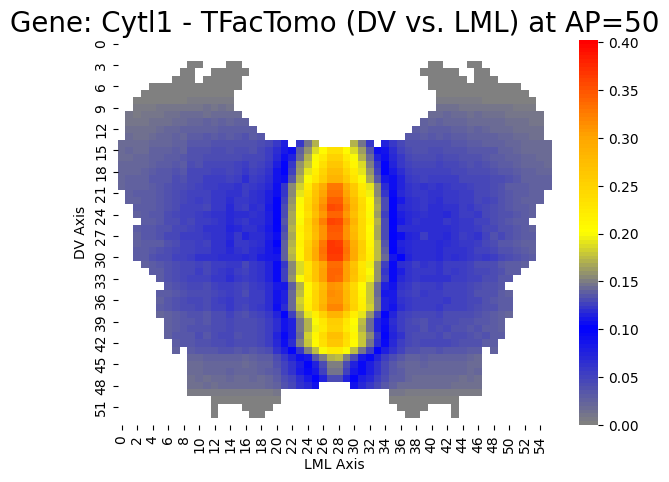

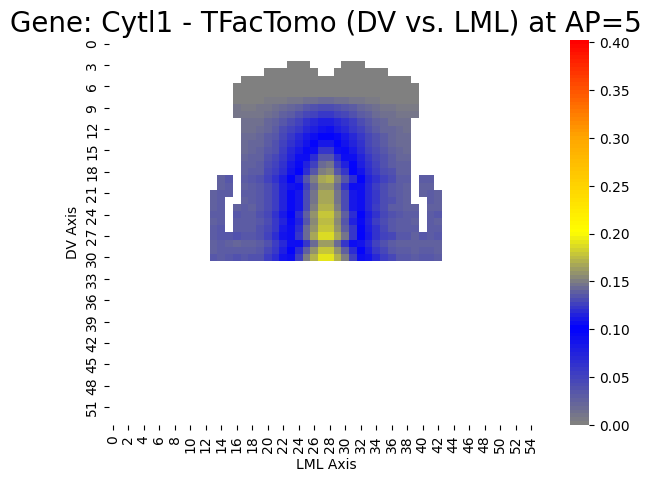

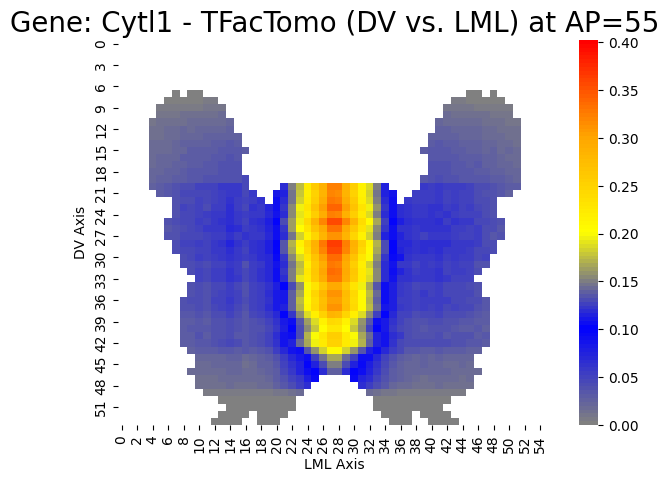

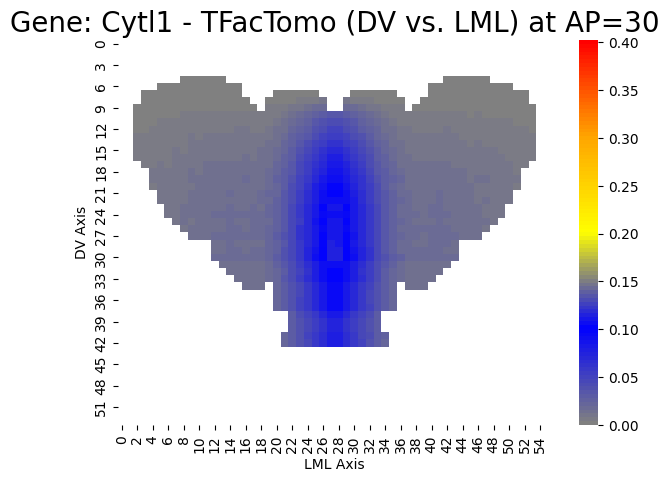

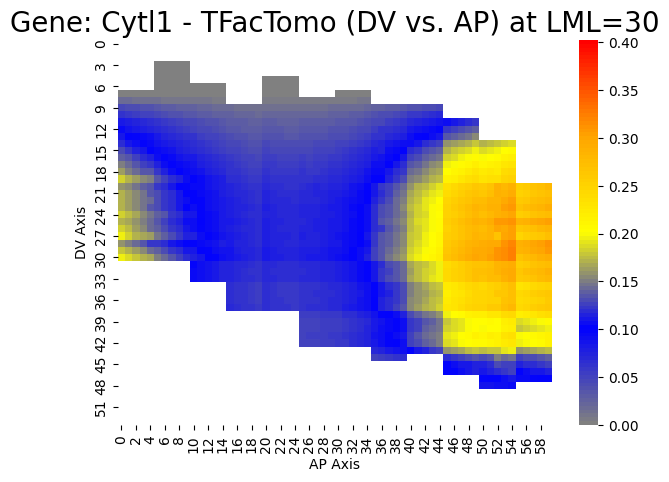

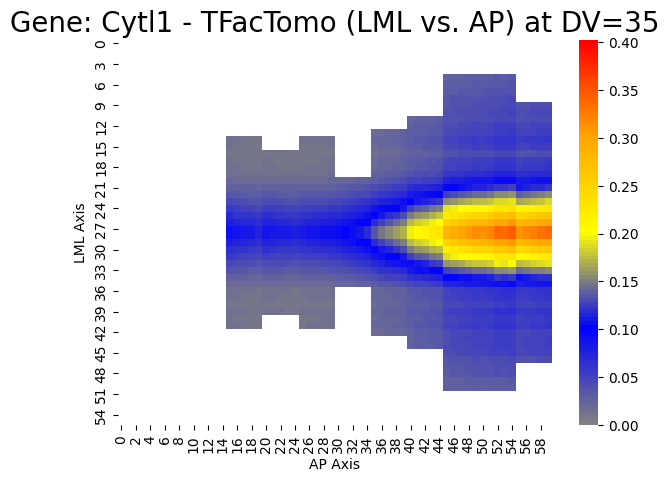

no volumen norm.


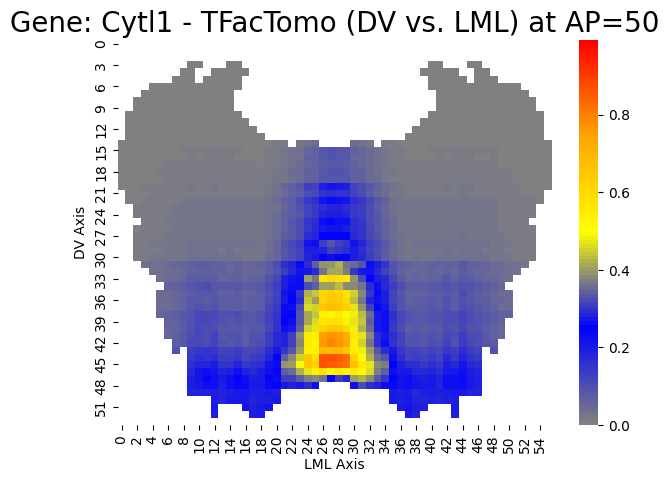

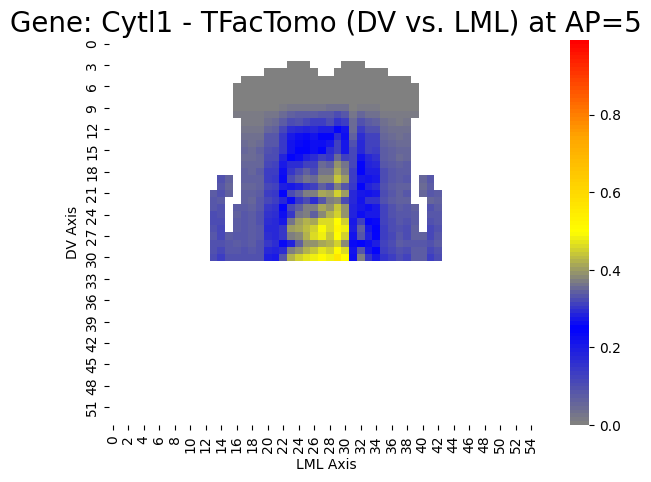

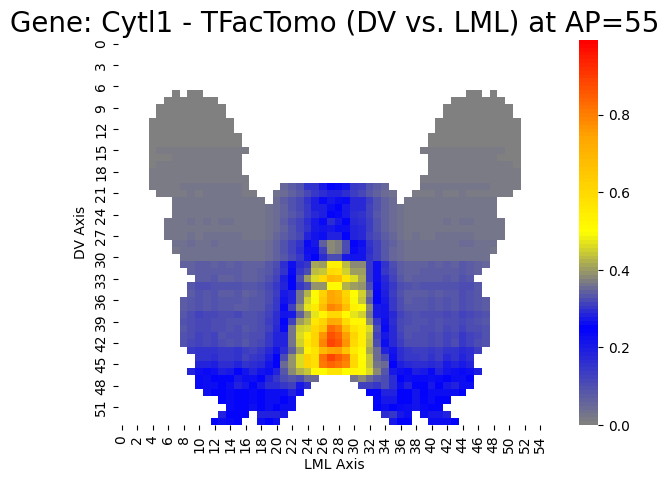

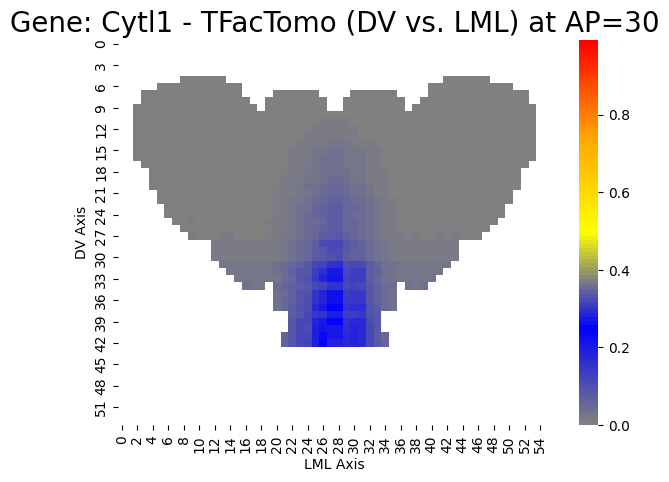

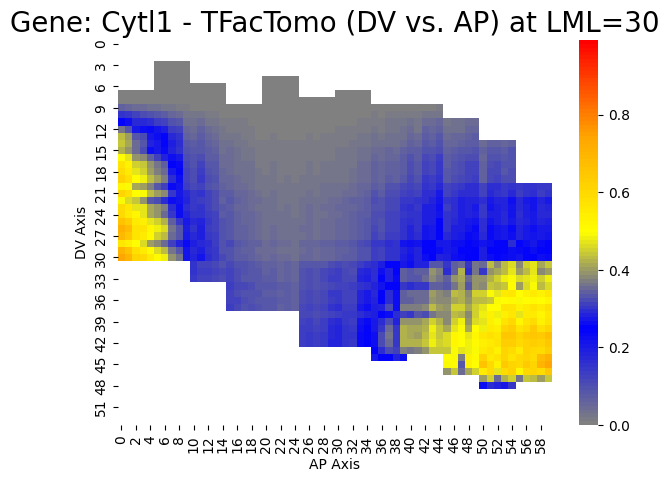

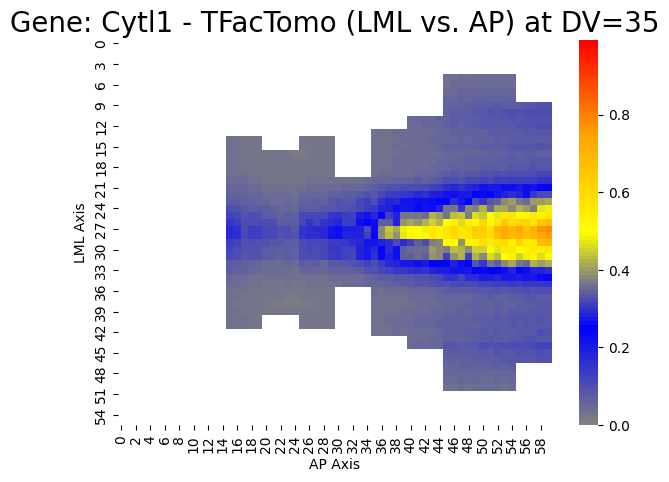

In [1058]:
import tensorly as tl_np
tl_np.set_backend('numpy')

# 1) Move them to CPU / NumPy
factors_mayra = [A.cpu().numpy() for A in A_mayra]

factors_no_vol = [A.cpu().numpy() for A in A_mayra_no_vol]



# 2) Reconstruct the full (1 × 54 × 56 × 60) tensor
T_all_mayra = tl_np.cp_tensor.cp_to_tensor((None, factors_mayra))
T_no_vol = tl_np.cp_tensor.cp_to_tensor((None, factors_no_vol))

"""# 1) load your CP factors A = [A_g, A_x, A_y, A_z]
A = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/results/mouse_olfactory_mucosa_CPD_factors_fixed1.pt")
# make sure tensorly uses numpy backend
tl.set_backend('numpy')
"""

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["gray", "blue", "yellow", "orange", "red"], N=100
)


vol3d = T_all_mayra[0]     # shape → (54, 56, 60)

# 4) Scale & log‐transform just like your IPF
proj_scaled = vol3d * (av_gene_counts / vol3d.sum())
vol3d   = np.log10(proj_scaled + 1)

#vol3d = np.log10(vol3d +1)

#vol3d = np.log10(vol3d + 1)
# 5) load your tissue mask (same dimensions as vol3d)
mask = M

white_cmap = ListedColormap(["white"])
slice_idx = 50  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 5  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 55  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=vol3d.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 30  # e.g. AP slice
pa_slice = vol3d[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = vol3d[:, slice_idx, :]
mask_lml_slice = M[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(lml_slice, cmap=r_palette,vmin=0, vmax=vol3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. AP) at LML={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 35
dv_slice = vol3d[slice_idx, :, :]
mask_dv_slice = M[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(dv_slice, cmap=r_palette,vmin=0, vmax=vol3d.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (LML vs. AP) at DV={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()


### without volume ###

print('no volumen norm.')


no_vol_3d = T_no_vol[0]     # shape → (54, 56, 60)

# 4) Scale & log‐transform just like your IPF
proj_scaled = no_vol_3d * (av_gene_counts / vol3d.sum())
vol3d_no    = np.log10(proj_scaled + 1)

#vol3d = np.log10(vol3d +1)

#vol3d = np.log10(vol3d + 1)
# 5) load your tissue mask (same dimensions as vol3d)
mask = M

white_cmap = ListedColormap(["white"])
slice_idx = 50  # e.g. AP slice
pa_slice = vol3d_no[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d_no.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 5  # e.g. AP slice
pa_slice = vol3d_no[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d_no.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 55  # e.g. AP slice
pa_slice = vol3d_no[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0, vmax=vol3d_no.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

slice_idx = 30  # e.g. AP slice
pa_slice = vol3d_no[:, :, slice_idx]
mask_pa_slice = M[:, :, slice_idx]
mask_overlay = np.where(mask_pa_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=0,vmax=vol3d_no.max(),  annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. LML) at AP={slice_idx}", fontsize=20)
plt.xlabel("LML Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along LML axis
slice_idx = 30
lml_slice = vol3d_no[:, slice_idx, :]
mask_lml_slice = M[:, slice_idx, :]
mask_overlay = np.where(mask_lml_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(lml_slice, cmap=r_palette,vmin=0, vmax=vol3d_no.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (DV vs. AP) at LML={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("DV Axis")
plt.show()

# Slice along DV axis
slice_idx = 35
dv_slice = vol3d_no[slice_idx, :, :]
mask_dv_slice = M[slice_idx, :, :]
mask_overlay = np.where(mask_dv_slice == 0, 1, np.nan)

plt.figure(figsize=(7, 5))
sns.heatmap(dv_slice, cmap=r_palette,vmin=0, vmax=vol3d_no.max(), annot=False)
sns.heatmap(mask_overlay, cmap=white_cmap, annot=False, cbar=None)
plt.title(f"Gene: Cytl1 - TFacTomo (LML vs. AP) at DV={slice_idx}", fontsize=20)
plt.xlabel("AP Axis")
plt.ylabel("LML Axis")
plt.show()





In [1018]:
#tfactomo_results = tfactomo_3d(seed_3d.copy(), target_DV, target_LML, target_PA)

# tfactomo Reconstruction
tfactomo_sum_x = vol3d.sum(axis=(1, 2))
tfactomo_sum_y = vol3d.sum(axis=(0, 2))
tfactomo_sum_z = vol3d.sum(axis=(0, 1))

# DV-axis
mse_DV_tfactomo1, map_DV_tfactomo1, corr_DV_tfactomo1 = evaluation(tfactomo_sum_x, target_DV)

# LML-axis
mse_LML_tfactomo1, map_LML_tfactomo1, corr_LML_tfactomo1 = evaluation(tfactomo_sum_y, target_LML)

# AP-axis
mse_AP_tfactomo1, map_AP_tfactomo1, corr_AP_tfactomo1 = evaluation(tfactomo_sum_z, target_PA)

print('tfactomo1:')
print(f'mse DV: {mse_DV_tfactomo1}, mse LML: {mse_LML_tfactomo1}, mse AP: {mse_AP_tfactomo1}')
print(f'map LML: {map_DV_tfactomo1}, map LML: {map_LML_tfactomo1}, map AP: {map_AP_tfactomo1}')
print(f'corr DV: {corr_DV_tfactomo1}, corr LML: {corr_LML_tfactomo1}, corr AP: {corr_AP_tfactomo1}')

print(mse_DV_tfactomo1, mse_LML_tfactomo1, mse_AP_tfactomo1)
print(map_DV_tfactomo1, map_LML_tfactomo1, map_AP_tfactomo1)
print(corr_DV_tfactomo1, corr_LML_tfactomo1, corr_AP_tfactomo1)



# no volume #



tfactomo1:
mse DV: 4.000558012410753, mse LML: 1.1697202587692055, mse AP: 1.092142735819454
map LML: 1.89100480289011, map LML: 1.0809931048310144, map AP: 1.0435554430134553
corr DV: 0.9912955394994063, corr LML: 0.9999955373358708, corr AP: 0.9998239428325958
4.000558012410753 1.1697202587692055 1.092142735819454
1.89100480289011 1.0809931048310144 1.0435554430134553
0.9912955394994063 0.9999955373358708 0.9998239428325958


In [1051]:

# tfactomo Reconstruction
tfactomo_sum_x_no = no_vol_3d.sum(axis=(1, 2))
tfactomo_sum_y_no = no_vol_3d.sum(axis=(0, 2))
tfactomo_sum_z_no = no_vol_3d.sum(axis=(0, 1))

# DV-axis
mse_DV_tfactomo1, map_DV_tfactomo1, corr_DV_tfactomo1 = evaluation(tfactomo_sum_x_no, target_DV_no_volume)

# LML-axis
mse_LML_tfactomo1, map_LML_tfactomo1, corr_LML_tfactomo1 = evaluation(tfactomo_sum_y_no, target_LML_no_volume)

# AP-axis
mse_AP_tfactomo1, map_AP_tfactomo1, corr_AP_tfactomo1 = evaluation(tfactomo_sum_z_no, target_PA_no_volume)

print('tfactomo1:')
print(f'mse DV: {mse_DV_tfactomo1}, mse LML: {mse_LML_tfactomo1}, mse AP: {mse_AP_tfactomo1}')
print(f'map LML: {map_DV_tfactomo1}, map LML: {map_LML_tfactomo1}, map AP: {map_AP_tfactomo1}')
print(f'corr DV: {corr_DV_tfactomo1}, corr LML: {corr_LML_tfactomo1}, corr AP: {corr_AP_tfactomo1}')

print(mse_DV_tfactomo1, mse_LML_tfactomo1, mse_AP_tfactomo1)
print(map_DV_tfactomo1, map_LML_tfactomo1, map_AP_tfactomo1)
print(corr_DV_tfactomo1, corr_LML_tfactomo1, corr_AP_tfactomo1)

tfactomo1:
mse DV: 22249.678144074063, mse LML: 11052.343877781559, mse AP: 2556.648425223329
map LML: 144.32904461140436, map LML: 105.12212187494262, map AP: 50.41129562794115
corr DV: 0.9925214233737831, corr LML: 0.999983459344914, corr AP: 0.9995467698089171
22249.678144074063 11052.343877781559 2556.648425223329
144.32904461140436 105.12212187494262 50.41129562794115
0.9925214233737831 0.999983459344914 0.9995467698089171


 ||target_DV - IPF_x||  = 2.280182088532257
 ||target_LML – IPF_y|| = 1.1118544326643933
 ||target_LML – IPF_y|| = 1.105674503339161


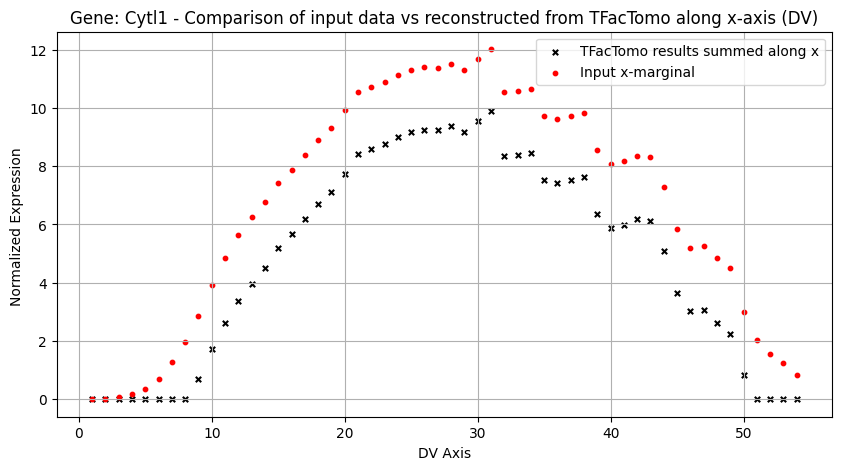

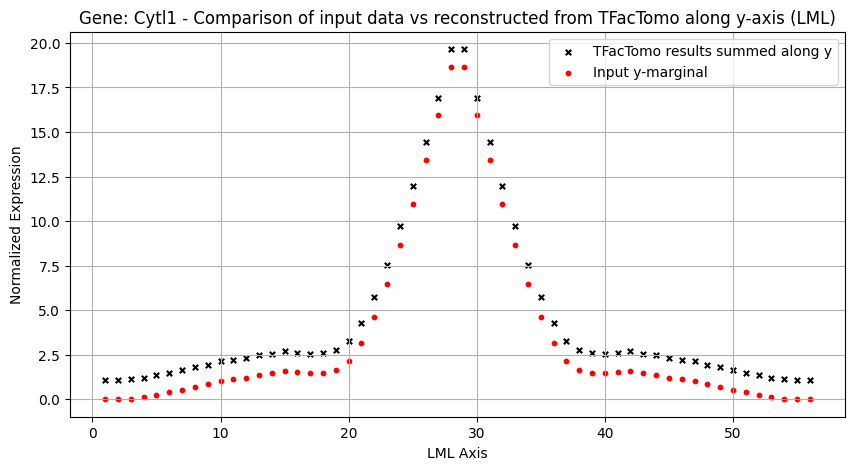

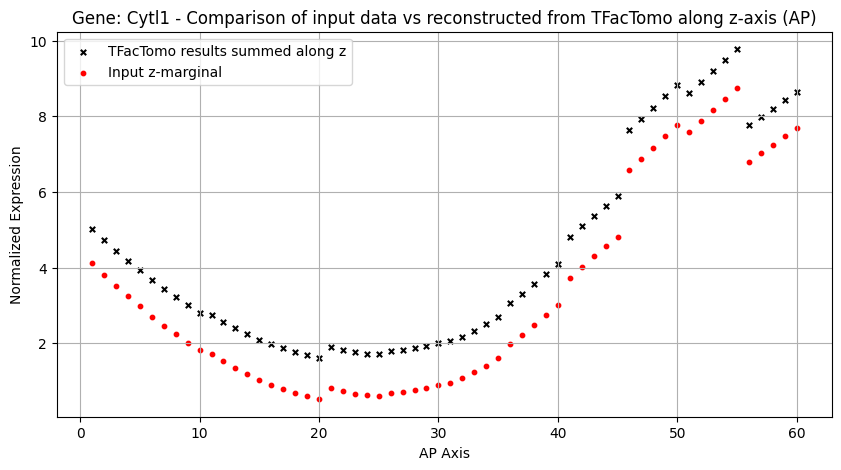

In [1001]:

# using the modified ipf function from the TFacTomo authors for the data of Mayra

''' 
Reminder:

X_x = DV data --> size: 9254 x 54
X_y = LML data --> size: 9254 x 56
X_z = PA data --> size: 9254 x 60
'''


# 1) Compute marginals
ipf_sum_x_ = vol3d.sum(axis=(1, 2))
ipf_sum_y_ = vol3d.sum(axis=(0, 2))
ipf_sum_z_ = vol3d.sum(axis=(0, 1))


diff_x_ = ipf_sum_x_ - target_DV       # length‐n_x array
diff_y_ = ipf_sum_y_ - target_LML    # length‐n_y array
diff_z_ = ipf_sum_z_ - target_PA      # length‐n_z array

# 3) Print a quick summary
print(" ||target_DV - IPF_x||  =", np.max(np.abs(diff_x_)))
print(" ||target_LML – IPF_y|| =", np.max(np.abs(diff_y_)))
print(" ||target_LML – IPF_y|| =", np.max(np.abs(diff_z_)))


# draw results

x = np.arange(1, len(target_DV) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(x, ipf_sum_x_, s=15, c='k', marker='x',label= 'TFacTomo results summed along x')
plt.scatter(x, target_DV, s=10, c='red', label='Input x-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from TFacTomo along x-axis (DV)")
plt.xlabel("DV Axis")
plt.ylabel("Normalized Expression ")
plt.legend()
plt.grid()
plt.show()

y = np.arange(1, len(target_LML) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(y, ipf_sum_y_, s=15, c='k',marker='x',label= 'TFacTomo results summed along y')
plt.scatter(y, target_LML, s=10, c='red', label='Input y-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from TFacTomo along y-axis (LML)")
plt.xlabel("LML Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()

z = np.arange(1, len(target_PA) + 1)
plt.figure(figsize=(10, 5))
plt.scatter(z, ipf_sum_z_, s=15, marker='x', c='k', label= 'TFacTomo results summed along z')
plt.scatter(z, target_PA, s=10, c='red', label='Input z-marginal')

plt.title(f"Gene: Cytl1 - Comparison of input data vs reconstructed from TFacTomo along z-axis (AP)")
plt.xlabel("AP Axis")
plt.ylabel("Normalized Expression")
plt.legend()
plt.grid()
plt.show()
